# Astro Hack Week

The goal is to create an automated Voigt profile model to high resolution astrophysical spectra.

This notebook aims to show the current state.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
import warnings
import string
import astropy
import pymc as mc
import itertools as it
from glob import glob
import datetime

import barak
from barak import absorb
from barak import convolve
from barak import voigt
from barak import pyvpfit

In [2]:
warnings.simplefilter("ignore")
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_context('poster', font_scale=1.3)

In [3]:
atomDict = absorb.readatom('../data/MM_VPFIT_2012-06-05_noiso.dat')
pixel_size = 1.3 # km/s per pixel
subsample_factor = int(1)

In [4]:
def VoigtAbsorption(x):
    return np.exp(-x)

def subsample(wave, subsample_factor=subsample_factor, pixel_size=pixel_size):
    # Assumes wave was created by make_constant_dv_wa_scale
    # pixel_size is in km/s of the original wave array
    begin_size = wave[1] - wave[0]
    end_size = wave[-1] - wave[-2]
    subwave = barak.sed.make_constant_dv_wa_scale(wave[0] - begin_size/2.0, wave[-1] + end_size, pixel_size/subsample_factor)
    return subwave[:len(wave) * subsample_factor]

def co_add_from_subsample(subsampled_flux, subsample_factor=subsample_factor):
    starting_length = len(subsampled_flux)
    intermediate_step = subsampled_flux.reshape(starting_length/subsample_factor, subsample_factor)/float(subsample_factor)
    return np.sum(intermediate_step, axis=1)

def create_wavelength_chunk(rest_wavelength, z_begin, z_end, pixel_size=1.3, tolerance=2.0):
    """Returns a wavelength array that covers the redshift range of interest
    for a given transition.
    pixel_size in km/s
    tolerance in Angstroms."""
    starting = (z_begin + 1 ) * rest_wavelength
    ending = (z_end + 1 ) * rest_wavelength
    return barak.sed.make_constant_dv_wa_scale(starting - tolerance, ending + tolerance, pixel_size)


In [5]:
onesigmaerror = 0.02
#onesigmaerror = np.average(err1)
instrument_profile = 5.0 #km/s
estimated_instrument_profile = 5.0

z_lower = 1.6272486
z_upper = 1.6282109
b_lower = 3.0
b_upper = 7.5
N_lower = 9.5
N_upper = 13.0
line_list = []

species = {}
species['FeII'] = {}
# species['FeII']['1608'] = 1608.4507986
#species['FeII']['1611'] = 1611.2004037
species['FeII']['2382'] = 2382.7640777
# species['FeII']['2600'] = 2600.1721140
# species['FeII']['2344'] = 2344.2127470
# species['FeII']['2586'] = 2586.6493120
# species['AlII'] = {}
# species['AlII']['1670'] = 1670.7886100 

# species['AlIII'] = {}
# species['AlIII']['1862'] = 1862.798581
# species['AlIII']['1854'] = 1854.708966

# species['MgI'] = {}
# species['MgI']['2852'] = 2852.9627970

# species['MgII'] = {}
# species['MgII']['2796'] = 2796.3537860
# species['MgII']['2803'] = 2803.5309820


In [6]:
regions = []
wavelength_list = []
for specie in species:
    for transition in species[specie]:
        rest_wavelength = species[specie][transition]
        wave = create_wavelength_chunk(rest_wavelength, z_lower, z_upper)
        wavelength_list.append(wave)
        regions.append([specie, transition, np.average(wave)])
        
wavelength_list = np.array(wavelength_list)
wavelength = np.array(np.hstack(wavelength_list))
subwavelength_list = []
for cutwave in wavelength_list:
    subwavelength_list.append(subsample(cutwave))
subwavelength_list = np.array(subwavelength_list)

noise_list = np.array([np.random.normal(0.0, onesigmaerror, len(wave)) for wave in wavelength_list])
noise = np.hstack(noise_list)


In [7]:
# This is when you want to tie species together with fixed relative column densities
species_column_density_correction = {}
species_column_density_correction["MgI"] = -1.72
species_column_density_correction["MgII"] =  0.08
species_column_density_correction["AlII"] = -1.02
species_column_density_correction["AlIII"] = -1.62
species_column_density_correction["SiII"] =  0.06
species_column_density_correction["CrII"] = -1.82
species_column_density_correction["FeII"] =  0.00
species_column_density_correction["MnII"] = -1.97
species_column_density_correction["NiII"] = -1.25
species_column_density_correction["TiII"] = -1.54
species_column_density_correction["ZnII"] = -1.82

In [8]:
starting_model = [
#  ['FeII', 11.47903, 1.6272486, 5.8986],
#  ['FeII', 11.80684, 1.6273509, 4.9074],
#  ['FeII', 12.04197, 1.6274293, 4.2774],
 ['FeII', 12.53468, 1.6274744, 3.7264],
 ['FeII', 11.81651, 1.6275073, 3.0    ],
 ['FeII', 11.8325,  1.6275375, 2.036 ],
 ['FeII', 11.98327, 1.6275711, 4.9331],
 ['FeII', 12.53598, 1.6276858, 3.9991],
#  ['FeII', 12.37782, 1.6277142, 2.9156],
#  ['FeII', 12.04839, 1.6277377, 4.4162],
#  ['FeII', 12.14221, 1.6277991, 4.0641],
#  ['FeII', 12.60239, 1.6278632, 4.2045],
#  ['FeII', 12.4193,  1.6279151, 2.5551],
#  ['FeII', 12.84099, 1.6279648, 3.9983],
#  ['FeII', 11.9488,  1.628003,  1.1738],
#  ['FeII', 12.28364, 1.6280408, 3.766 ],
#  ['FeII', 11.72462, 1.6280943, 1.0938],
#  ['FeII', 11.49827, 1.6281306, 1.0164],
#  ['FeII', 11.08618, 1.6281681, 1.0   ],
#  ['FeII', 12.00147, 1.6282109, 8.2485],
]
true_components = len(starting_model)

In [9]:
true_component_parameters = []
for row in starting_model:
    for specie in species:
        true_component_parameters.append([specie, row[2], row[3], row[1] + species_column_density_correction[specie]])

In [10]:
gen_data = {}
for region_index, region_wavelength in enumerate(wavelength_list):
    gen_data[region_index] = {}
    flux = absorb.find_tau(subwavelength_list[region_index], true_component_parameters, atomDict, )[0]
    gen_data[region_index] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux), 
                                                                                     instrument_profile)) + noise_list[region_index]
total_observed = np.hstack([gen_data[region_index]
                            for region_index, region_wavelength in enumerate(wavelength_list)])

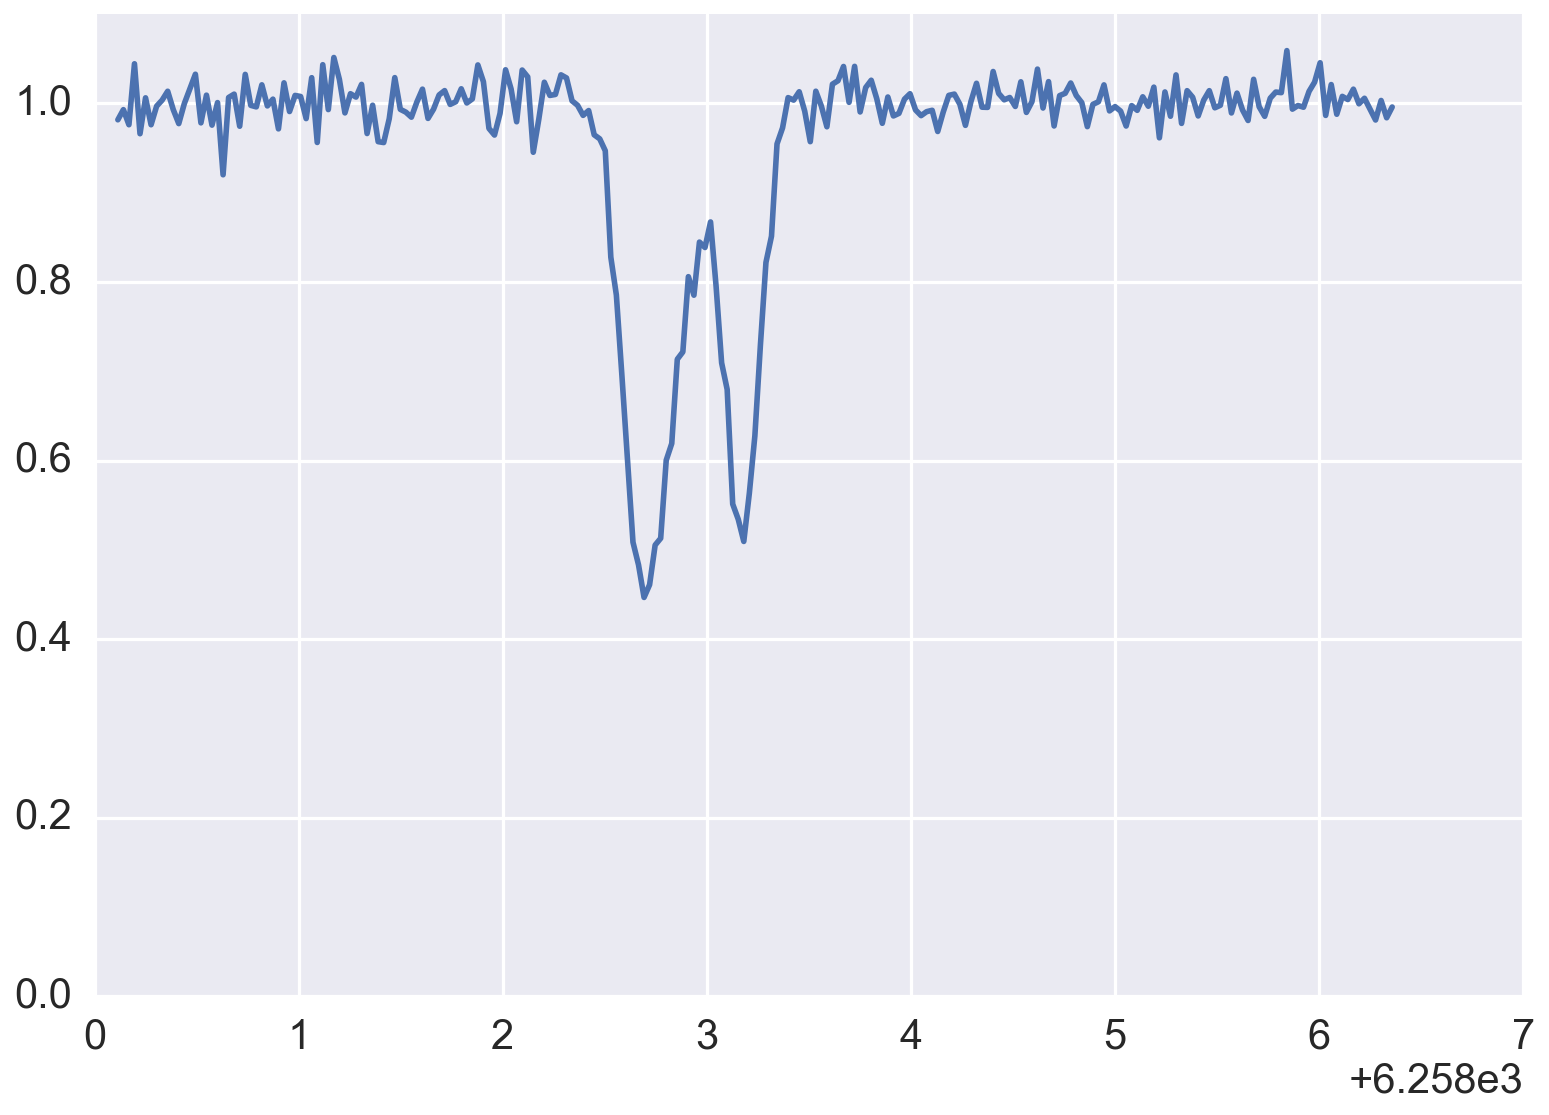

In [11]:
index = 0
plt.plot(wavelength_list[index], gen_data[index])
plt.ylim(0, 1.1);

In [12]:
# Write spectra files
wavelength_buffer = 2.0
lower_labels = []
for x in it.combinations_with_replacement(string.ascii_lowercase, 2):
    lower_labels.append(x[0] + x[1])

timestamp = "demo-data"

for i, region in enumerate(wavelength_list):
    np.savetxt(timestamp + "." + str(i) + regions[i][0] + ".ascii",
               (np.transpose([wavelength_list[i], gen_data[i], np.ones_like(region) * onesigmaerror])))


In [13]:
# # Read spectra
# leader_ion = "FeII"
# wavelength_list = []
# observed = []
# noise_list = []
# for infile in sorted(glob(timestamp + "*" + leader_ion + ".ascii")):
#     wav, flx, err = np.loadtxt(infile, unpack=True)
#     wavelength_list.append(wav)
#     observed.append(flx)
#     noise_list.append(err)

# err = np.hstack(noise_list)
# total_observed = np.hstack(observed)
# subwavelength_list = []
# for cutwave in wavelength_list:
#     subwavelength_list.append(subsample(cutwave))

# subwavelength_list = np.array(subwavelength_list)

In [14]:
#fit_species = "FeII"
fit_components = 5
N_tol = 0.1
b_tol = 0.1
z_tol = 0.00001
ip_tol = 0.5
estimated_variables = {}
fit_N_lower = N_lower - N_tol
fit_N_upper = N_upper + N_tol
fit_b_lower = 3.0
fit_b_upper = b_upper + 2 * b_tol
fit_z_lower = z_lower - z_tol
fit_z_upper = z_upper + z_tol
# Instrument profile
fit_instrument_profile_lower = instrument_profile - ip_tol
fit_instrument_profile_upper = instrument_profile + ip_tol

estimated_variables = {}
for index, redshift in enumerate(np.linspace(fit_z_lower, fit_z_upper, num=fit_components)):
    component = index
    estimated_variables[component] = {}
    estimated_variables[component]['fit_b'] = mc.Uniform("est_b_" + str(component), fit_b_lower, fit_b_upper)
    estimated_variables[component]['fit_z'] = mc.Uniform("est_z_" + str(component), fit_z_lower, fit_z_upper, value=redshift)

#estimated_instrument_profile = mc.Uniform("est_IP", fit_instrument_profile_lower, fit_instrument_profile_upper)
estimated_instrument_profile = instrument_profile

#std deviation of the noise, converted to precision by tau = 1/sigma**2
#std_deviation = 1./mc.Uniform("std", 0, 1)**2
#std_deviation = 1./(noise**2)
std_deviation = 1./(noise**2)

In [15]:
physical_fit_components = []
#for index, redshift in enumerate(np.linspace(fit_z_lower, fit_z_upper, num=fit_components)):
for component in range(fit_components):
    physical_fit_components.append([estimated_variables[component]['fit_z'],
                                    estimated_variables[component]['fit_b']])

regions = []
for specie in species:
    for transition in species[specie]:
        rest_wavelength = species[specie][transition]
        wave = create_wavelength_chunk(rest_wavelength, z_lower, z_upper)
        regions.append([specie, transition, np.average(wave)])

fit_component_parameters = []
for index in range(fit_components):
    component = index
    for specie in species:
        fit_component_parameters.append([specie,
                                         physical_fit_components[component][0],
                                         physical_fit_components[component][1],
                                         mc.Uniform("est_N_" + specie + "_" + str(component),
                                                    fit_N_lower,
                                                    fit_N_upper)])


In [16]:
@mc.deterministic(trace=False)
def generated_flux(regions=len(wavelength_list), 
                   fit_component_guesses=fit_component_parameters,
                   fit_instrument_profile=estimated_instrument_profile):
    """Creates the absorption for the components"""
    fit_flux = []
    for region_index in range(regions):
        flux = absorb.find_tau(subwavelength_list[region_index], fit_component_guesses, atomDict, )[0]
        fit_flux.append(co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux), fit_instrument_profile)))
    return np.hstack(fit_flux)


In [17]:
def generated_flux2(regions=len(wavelength_list), 
                   fit_component_guesses=fit_component_parameters,
                   fit_instrument_profile=estimated_instrument_profile):
    """Creates the absorption for the components"""
    fit_flux = []
    for region_index in range(regions):
        flux = absorb.find_tau(subwavelength_list[region_index], fit_component_guesses, atomDict, )[0]
        fit_flux.append(co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux), fit_instrument_profile)))
    return np.hstack(fit_flux)


In [18]:
potentials = {}
for component in range(fit_components - 1):
    @mc.potential
    def order_restriction(m1=estimated_variables[component]['fit_z'], 
                          m2=estimated_variables[component + 1]['fit_z']):
        if m1 < m2:
            return 0
        else:
            return 1 - np.exp(100000. * (m1 - m2))
    potentials[component] = order_restriction


In [19]:
observations = mc.Normal("obs", generated_flux, std_deviation, value=total_observed, observed=True)

In [20]:
m1 = mc.Model(list(set([x[1] for x in fit_component_parameters]))
              + list(set([x[2] for x in fit_component_parameters]))
              + list(set([x[3] for x in fit_component_parameters]))
              + [std_deviation]
              + [potentials[restriction] for restriction in potentials]
#               + [estimated_instrument_profile]
             )


In [21]:
map_ = mc.MAP(m1)
first_fit = datetime.datetime.now()
map_.fit()
print("Initial fit time: ", str(datetime.datetime.now() - first_fit))
m_sample = mc.MCMC(m1)

Initial fit time:  0:00:12.686459


In [ ]:
starttime = datetime.datetime.now()
print("Starting time: ", starttime)
iterations = 20000
burn=1000
thin=10.0
# %prun
m_sample.sample(iter=iterations, burn=burn, thin=thin)
finishtime = datetime.datetime.now()
sampletime = str(finishtime - starttime)
print("\nTook:", sampletime, " to finish", str(iterations), "iterations.")

Starting time:  2016-09-01 14:22:16.797061
 [----------       28%                  ] 5704 of 20000 complete in 65.9 sec

In [ ]:
final_fit = []
for row in fit_component_parameters:
    final_fit.append([row[0], row[1].value, row[2].value, row[3].value])

final_fit = sorted(final_fit, key=lambda x:x[1])

fit_flux = {}
for region_index, region_wavelength in enumerate(wavelength_list):
    fit_flux[region_index] = {}
    flux = absorb.find_tau(subwavelength_list[region_index], final_fit, atomDict, )[0]
    fit_flux[region_index]['flux'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux),
                                                                                 estimated_instrument_profile))

In [ ]:
for region_index, region_wavelength in enumerate(wavelength_list):
    print(region_index, len(region_wavelength))

In [ ]:
x_formatter = mpl.ticker.ScalarFormatter(useOffset=False)

In [ ]:
# pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")
for region_index, region_wavelength in enumerate(wavelength_list):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 2, 2])
    ax3 = plt.subplot(gs[2])
    ax1 = plt.subplot(gs[0], sharex=ax3)
    ax2 = plt.subplot(gs[1], sharex=ax3)
    ax1.plot(wavelength_list[region_index], (gen_data[region_index] - fit_flux[region_index]['flux']) / onesigmaerror)
    ax1.hlines(1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-')
    ax1.hlines(0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='black')
    ax1.hlines(-1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-')
    ax2.plot(wavelength_list[region_index], gen_data[region_index], label="Observed")
    ax2.plot(wavelength_list[region_index], fit_flux[region_index]['flux'], color='black', label="Fit")
    ax2.legend(loc='best')
    ax3.plot(wavelength_list[region_index], gen_data[region_index], label="Observed")
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="red", label="actual-subcomponents", linewidth=1.0)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="red", linewidth=1.0)
    for final_index, row in enumerate(final_fit):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if final_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="green", label="fit-subcomponents", linewidth=1.0)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="green", linewidth=1.0)
    ax3.plot(wavelength_list[region_index], fit_flux[region_index]['flux'], color='black', label="Full fit")
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit; " + str(iterations)+ "/" 
                  + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)
#     pdf.savefig()
#     plt.close()
# pdf.close()


In [ ]:
trace_dict = []
fit_flux = {}
final_fit = {}
names = [parameter.__name__ for row in sorted(fit_component_parameters) for parameter in row[1:]]
for trace_number in np.arange(-len(m_sample.trace(name)[:]), 0):
    final_fit[trace_number] = []
    data = [m_sample.trace(name)[trace_number] for name in sorted(names, key=lambda x: x.split('_')[-1])]
    final_fit[trace_number].append([['FeII'] + x for x in list([np.array(blah) 
                                                  for blah in data[x:x+3]] for x in xrange(0, len(data), 3))])
    fit_flux[trace_number] = {}
    for region_index, region_wavelength in enumerate(wavelength_list):
        fit_flux[trace_number][region_index] = {}
        flux = absorb.find_tau(subwavelength_list[region_index], final_fit[trace_number][0], atomDict, )[0]
        fit_flux[trace_number][region_index]['flux'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux),
                                                                                     estimated_instrument_profile))
    trace_dict.append(fit_flux)


In [ ]:
# pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")


for region_index, region_wavelength in enumerate(wavelength_list):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 2, 2])
    ax3 = plt.subplot(gs[2])
    ax1 = plt.subplot(gs[0], sharex=ax3)
    ax2 = plt.subplot(gs[1], sharex=ax3)
    ax1.hlines(1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax1.hlines(0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='black', 
                 lw=0.5,)
    ax1.hlines(-1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax2.plot(wavelength_list[region_index], gen_data[region_index], label="Observed",
                 alpha=0.8,
                 lw=0.5,
            )
    ax2.legend(loc='best')
    ax3.plot(wavelength_list[region_index], gen_data[region_index], label="Observed", 
                 alpha=0.8,
                 lw=0.5,
            )
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="red", label="actual-subcomponents", 
                 lw=0.5,)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="red", 
                 lw=0.5,)
    for trace_number in np.arange(-200, 0):
        for final_index, row in enumerate(final_fit[trace_number][0]):
            flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
            flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
#             if final_index == 0:
#                 ax3.plot(wavelength_list[region_index], flux, color="green", label="fit-subcomponents", linewidth=1.0)
#             else:
            ax3.plot(wavelength_list[region_index], flux, color="green", lw=0.5, alpha=0.1)
        ax1.plot(wavelength_list[region_index], (gen_data[region_index] - fit_flux[trace_number][region_index]['flux']) / onesigmaerror, 
                 lw=0.5,
                 c='k'
                )
        ax2.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 alpha=0.3,
                 lw=0.5,
#                  label="Fit",
                )
        ax3.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 lw=0.5,)
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit; " + str(iterations)+ "/" 
                  + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)
#     pdf.savefig()
#     plt.close()
# pdf.close()


# Enter emcee

This idea borrowed from: http://twiecki.github.io/blog/2013/09/23/emcee-pymc/

In [453]:
import emcee

In [454]:
import copy

In [455]:
# m = copy.copy(m_sample)
m = copy.copy(m1)

In [456]:
sorted([x.__name__ for x in sorted(m.stochastics, key=lambda x: x.__name__)], key=lambda x: x.split('_')[-1])

['est_N_FeII_0',
 'est_b_0',
 'est_z_0',
 'est_N_FeII_1',
 'est_b_1',
 'est_z_1',
 'est_N_FeII_2',
 'est_b_2',
 'est_z_2',
 'est_N_FeII_3',
 'est_b_3',
 'est_z_3',
 'est_N_FeII_4',
 'est_b_4',
 'est_z_4']

In [513]:
# This is the likelihood function for emcee

# names = [x.__name__ for x in sorted(m.stochastics, key=lambda x: x.__name__)]
names = sorted([x.__name__ for x in sorted(m.stochastics, key=lambda x: x.__name__)], key=lambda x: x.split('_')[-1])
def lnprob(vals): # vals is a vector of parameter values to try
    # Set each random variable of the pymc model to the value
    # suggested by emcee
    for val, name in zip(vals, new_names):
        stochastic_dict[name].value = val
        
    try:
        m.logp
    except mc.ZeroProbability:
        return -np.inf
    return m.logp

# emcee parameters
ndim = len(m.stochastics)

In [514]:
def sortlist(stochastic):
    name = x.__name__
    comp = int(name.split('_')[-1])
    return (comp, name)

In [515]:
[x for x in sorted(m.stochastics, key=sortlist)]

[<pymc.distributions.Uniform 'est_b_3' at 0x11c518cd0>,
 <pymc.distributions.Uniform 'est_N_FeII_2' at 0x11c518250>,
 <pymc.distributions.Uniform 'est_N_FeII_3' at 0x11c518610>,
 <pymc.distributions.Uniform 'est_N_FeII_0' at 0x11c5182d0>,
 <pymc.distributions.Uniform 'est_b_0' at 0x11c518490>,
 <pymc.distributions.Uniform 'est_z_2' at 0x11c5188d0>,
 <pymc.distributions.Uniform 'est_N_FeII_1' at 0x11f068790>,
 <pymc.distributions.Uniform 'est_z_0' at 0x11c5184d0>,
 <pymc.distributions.Uniform 'est_b_2' at 0x11c518ad0>,
 <pymc.distributions.Uniform 'est_z_4' at 0x11c5187d0>,
 <pymc.distributions.Uniform 'est_b_4' at 0x11c518d50>,
 <pymc.distributions.Uniform 'est_b_1' at 0x11f068a90>,
 <pymc.distributions.Uniform 'est_z_1' at 0x11f068190>,
 <pymc.distributions.Uniform 'est_z_3' at 0x11c5183d0>,
 <pymc.distributions.Uniform 'est_N_FeII_4' at 0x11c518150>]

In [516]:
[x for x in sorted(m.stochastics, key=lambda x: x.__name__)]

[<pymc.distributions.Uniform 'est_N_FeII_0' at 0x11c5182d0>,
 <pymc.distributions.Uniform 'est_N_FeII_1' at 0x11f068790>,
 <pymc.distributions.Uniform 'est_N_FeII_2' at 0x11c518250>,
 <pymc.distributions.Uniform 'est_N_FeII_3' at 0x11c518610>,
 <pymc.distributions.Uniform 'est_N_FeII_4' at 0x11c518150>,
 <pymc.distributions.Uniform 'est_b_0' at 0x11c518490>,
 <pymc.distributions.Uniform 'est_b_1' at 0x11f068a90>,
 <pymc.distributions.Uniform 'est_b_2' at 0x11c518ad0>,
 <pymc.distributions.Uniform 'est_b_3' at 0x11c518cd0>,
 <pymc.distributions.Uniform 'est_b_4' at 0x11c518d50>,
 <pymc.distributions.Uniform 'est_z_0' at 0x11c5184d0>,
 <pymc.distributions.Uniform 'est_z_1' at 0x11f068190>,
 <pymc.distributions.Uniform 'est_z_2' at 0x11c5188d0>,
 <pymc.distributions.Uniform 'est_z_3' at 0x11c5183d0>,
 <pymc.distributions.Uniform 'est_z_4' at 0x11c5187d0>]

In [517]:
new_names = sorted([x.__name__ for x in sorted(m.stochastics, key=lambda x: x.__name__)], key=lambda x: int(x.split('_')[-1]))

In [518]:
temp_list = []
for x in m.stochastics:
    temp_list.append([x.__name__, x])
# valdict = dict(zip(names, vals))
stochastic_dict = dict(temp_list)

In [519]:
for name in new_names:
    print(name, stochastic_dict[name])

est_N_FeII_0 est_N_FeII_0
est_b_0 est_b_0
est_z_0 est_z_0
est_N_FeII_1 est_N_FeII_1
est_b_1 est_b_1
est_z_1 est_z_1
est_N_FeII_2 est_N_FeII_2
est_b_2 est_b_2
est_z_2 est_z_2
est_N_FeII_3 est_N_FeII_3
est_b_3 est_b_3
est_z_3 est_z_3
est_N_FeII_4 est_N_FeII_4
est_b_4 est_b_4
est_z_4 est_z_4


In [523]:
# Find MAP
mc.MAP(m).fit()
start = np.empty(ndim)
for i, var in enumerate(new_names):
    start[i] = stochastic_dict[var].value
# for i, var in enumerate(sorted([x.__name__ for x in sorted(m.stochastics, key=lambda x: x.__name__)], key=lambda x: x.split('_')[-1])):
#     start[i] = var.value

TypeError: __init__() got multiple values for keyword argument 'input'

In [522]:
lnprob(start)

17.659297796003404

In [521]:
start

array([ 12.46848715,   6.95410879,   1.62748045,   9.4       ,
         7.23055177,   1.62747193,  12.41635944,   6.00729154,
         1.6274634 ,  11.70553384,   7.7       ,   1.62751453,
        13.00060705,   4.60943188,   1.62763926])

In [ ]:
# p1[:, 0] < 9.5
# p1[:, 0] > 13.0
# p1[:, 1] < 3.0
# p1[:, 1] > 7.5
# p1[:, 2] < 1.6272486
# p1[:, 2] > 1.6282109

In [448]:
# lnprob(start)

In [ ]:
lnprob([12.53468, 3.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, ])

In [466]:
lnprob([12.53468, 3.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, ])

20.348592344585207

In [485]:
p1[0]

array([ 12.46245525,   6.94366506,   1.62748159,   9.39096678,
         7.24745147,   1.62747308,  12.42643442,   5.99798914,
         1.62746799,  11.69671356,   7.70795494,   1.62751114,
        12.999563  ,   4.58927249,   1.62764339])

In [524]:
newstart = []
for index, thing in enumerate(start):
    if not index % 3:
        newstart.append(np.average([thing, 9.5, 13.0 ]))
    if not (index + 1) % 3:
        newstart.append(np.average([thing, 1.6272486,  1.6282109 ]))
    if not (index + 2) % 3:
        newstart.append(np.average([thing, 3.0, 7.5 ]))
# p1[:, 0] < 9.5
# p1[:, 0] > 13.0
# p1[:, 1] < 3.0
# p1[:, 1] > 7.5
# p1[:, 2] < 1.6272486
# p1[:, 2] > 1.6282109
newstart = np.array(newstart)

In [586]:
newstart

array([ 11.65616238,   5.81803626,   1.62764665,  10.63333333,
         5.91018392,   1.62764381,  11.63878648,   5.50243051,
         1.62764097,  11.40184461,   6.06666667,   1.62765801,
        11.83353568,   5.03647729,   1.62769959])

In [589]:
newnewstart =  np.array([11.872786031717862,
 3.1142134809266921,
 1.6274960738919868,
 12.472575574821395,
 3.0757545215748667,
 1.6274768372410149,
 12.173285146519003,
 3.3681767872801456,
 1.6275445110177369,
 12.419403066828634,
 4.6946261662198205,
 1.6276786429421424,
 11.994336195491135,
 3.0019008171281132,
 1.6276947938337658,])

In [594]:
# start = np.array([ 12.46848715,   6.95410879,   1.62748045,   9.4       ,
#          7.23055177,   1.62747193,  12.41635944,   6.00729154,
#          1.6274634 ,  11.70553384,   7.7       ,   1.62751453,
#         13.00060705,   4.60943188,   1.62763926])

array([ 12.46848715,   6.95410879,   1.62748045,   9.4       ,
         7.23055177,   1.62747193,  12.41635944,   6.00729154,
         1.6274634 ,  11.70553384,   7.7       ,   1.62751453,
        13.00060705,   4.60943188,   1.62763926])

In [595]:
newstart = []
for index, thing in enumerate(newnewstart):
    if not index % 3:
        newstart.append(np.average([thing, 9.5, 13.0 ]))
    if not (index + 1) % 3:
        newstart.append(np.average([thing, 1.6272486,  1.6282109 ]))
    if not (index + 2) % 3:
        newstart.append(np.average([thing, 3.0, 7.5 ]))
# p1[:, 0] < 9.5
# p1[:, 0] > 13.0
# p1[:, 1] < 3.0
# p1[:, 1] > 7.5
# p1[:, 2] < 1.6272486
# p1[:, 2] > 1.6282109
newstart = np.array(newstart)

In [596]:
lnprob(newstart)

19.449793120437356

In [598]:
nwalkers = 250
p1 = emcee.utils.sample_ball(newstart, np.array(components * [.4, 0.5, 0.00001]), size=nwalkers)
arg = []
for walker in p1:
    arg.append(lnprob(walker))
print(np.sum(np.isfinite(arg)), arg)

250 [14.697734096405807, 10.402135643062449, 20.17462672293377, 20.348592344585207, 14.928123266564164, 20.348592344585207, 19.211434073616704, 19.921310447484785, 17.413889702342463, 20.348592344585207, 19.831886181166233, 20.290815793493717, 19.721100373406312, 6.065281409322449, 19.488497127483754, 20.348592344585207, 7.4337116838424, 16.44642597727163, 19.72573293521727, 20.348592344585207, 18.52588538648773, 18.916674636600415, 20.18235589505615, 13.189344696460306, 18.169524271901953, 3.443792579130383, 12.477144929050919, 20.103318558761103, 13.84176571753575, 19.41201581558664, 15.775270814235146, 19.60434684295013, 20.34755409297036, 13.627118470213137, 18.675761971033577, 14.524294953209154, 20.348592344585207, 18.07736321394144, 12.225661885296285, 14.659840705188135, 19.00396897559403, 19.254744879391357, 20.20669535972113, 19.40884769002939, 20.348592344585207, 17.56919487565142, 19.797936628916986, -33.54812751590417, 19.209247939971323, 19.662208127279406, 18.92079763739

In [599]:
lnprob([11.53468, 4.7264, 1.6274744, 12.53468, 4.7264, 1.6275744, 12.53468, 4.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, 12.53468, 4.7264, 1.6274744, ])

-22005.117202437876

In [562]:
# components = 5
# zvals = np.random.rand(nwalkers * components) * (z_upper - z_lower) + z_lower
# bvals = np.random.rand(nwalkers * components) * (b_upper - b_lower) + b_lower
# nvals = np.random.rand(nwalkers * components) * (N_upper - N_lower) + N_lower

# p0 = np.column_stack([nvals, bvals, zvals])

In [563]:
# [item for sublist in list([nvals[i], bvals[i], zvals[i]] for i in range(len(zvals))) for item in sublist]
# allvariables = [item for sublist in list([nvals[i], bvals[i], zvals[i]] for i in range(len(zvals))) for item in sublist]

In [564]:
# p0 = [allvariables[ix:ix + 3 * components] for ix in xrange(0, len(allvariables), 3 * components)]

In [600]:
lnprob(p1[0])

14.697734096405807

In [601]:
lnprob(p1[1])

10.402135643062449

In [603]:
# instantiate sampler passing in the pymc likelihood function
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

# burn-in
pos, prob, state = sampler.run_mcmc(p1, 1000)
sampler.reset()

In [604]:
sampler.run_mcmc(pos, 10000)

(array([[ 10.79225665,   3.81945694,   1.62727691, ...,  10.57189428,
           7.45009339,   1.62813002],
        [  9.97758452,   6.74422989,   1.62725088, ...,  12.5273834 ,
           4.35296826,   1.62815295],
        [  9.7262807 ,   5.51557539,   1.62725764, ...,  11.77607336,
           5.51200845,   1.62800351],
        ..., 
        [ 12.38208819,   4.25962486,   1.6273215 , ...,  10.65206568,
           5.79079357,   1.62819999],
        [  9.40313091,   4.10326788,   1.62775155, ...,  12.10422393,
           4.4412298 ,   1.62817814],
        [ 10.69188746,   6.80894199,   1.62726133, ...,  11.67530924,
           5.95207929,   1.62819237]]),
 array([ 20.34859234,  20.34859234,  20.34859234,  20.34859234,
         20.34859234,  20.34859234,  20.34859234,  20.34859234,
         20.34859234,  20.34859234,  20.34859234,  20.34859234,
         20.13656494,  20.34859234,  20.34859234,  20.34859234,
         20.34859234,  20.34859234,  20.34859234,  20.34859234,
         20.3485

In [605]:
mfinish = mc.MCMC(m)
mfinish.sample(1) # This call is to set up the chains

 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec

ZeroProbability: Stochastic est_b_0's value is outside its support,
 or it forbids its parents' current values.

In [606]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.106


Plotting est_N_FeII_3
Plotting est_N_FeII_2
Plotting est_b_0
Plotting est_z_0
Plotting est_N_FeII_0
Plotting est_z_2
Plotting est_b_2
Plotting est_b_3
Plotting est_z_1
Plotting est_b_4
Plotting est_z_4
Plotting est_b_1
Plotting est_N_FeII_1
Plotting est_z_3
Plotting est_N_FeII_4


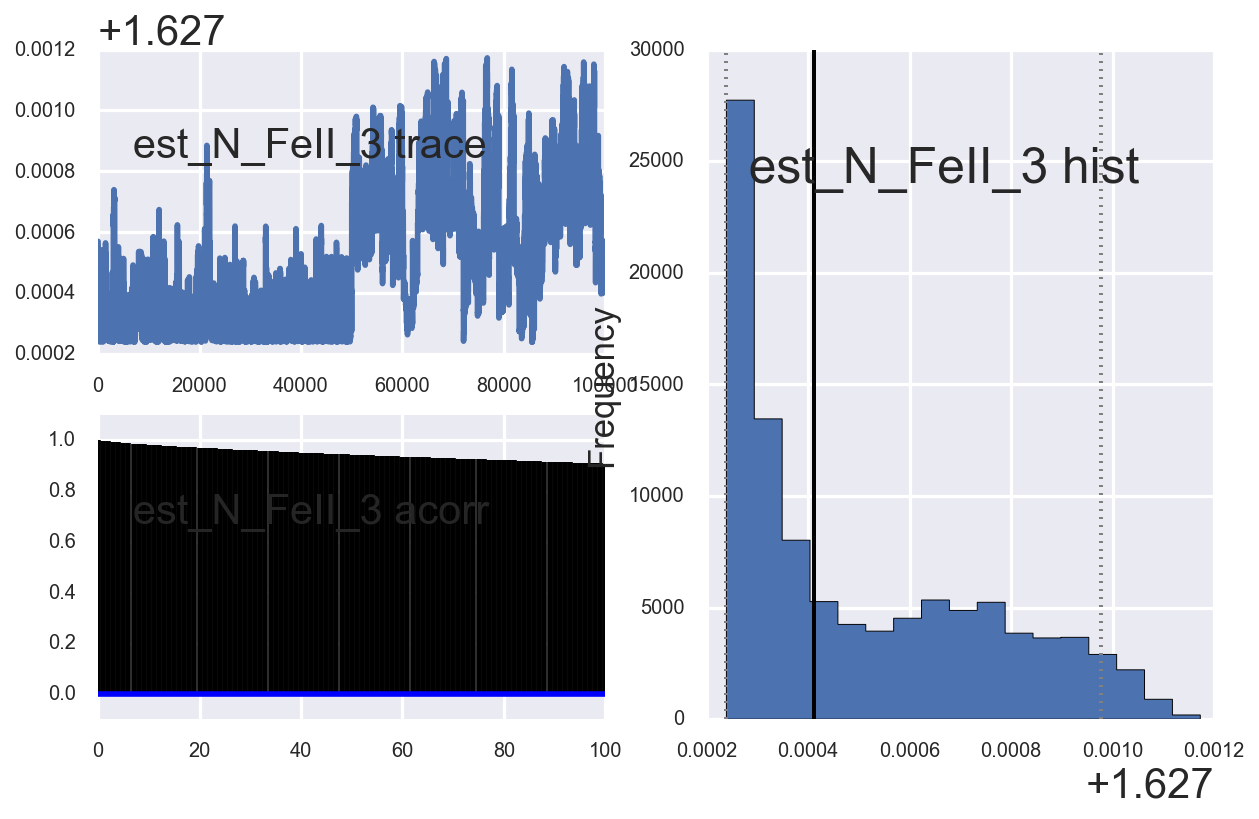

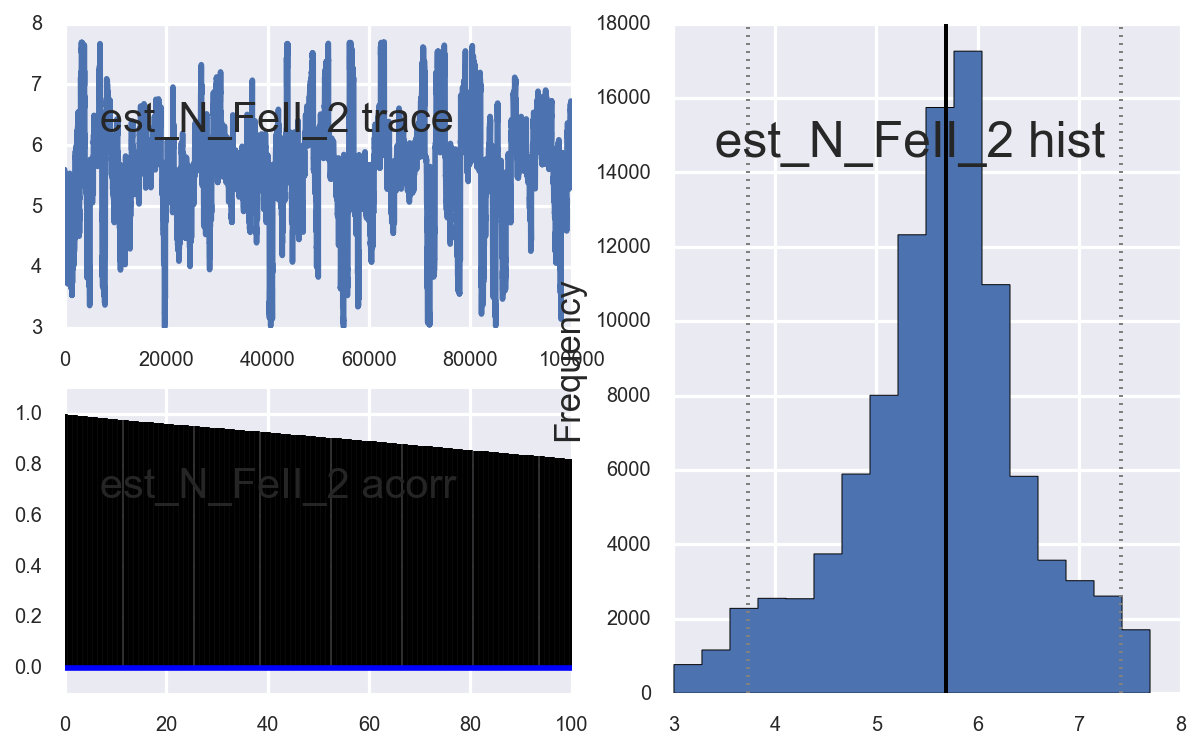

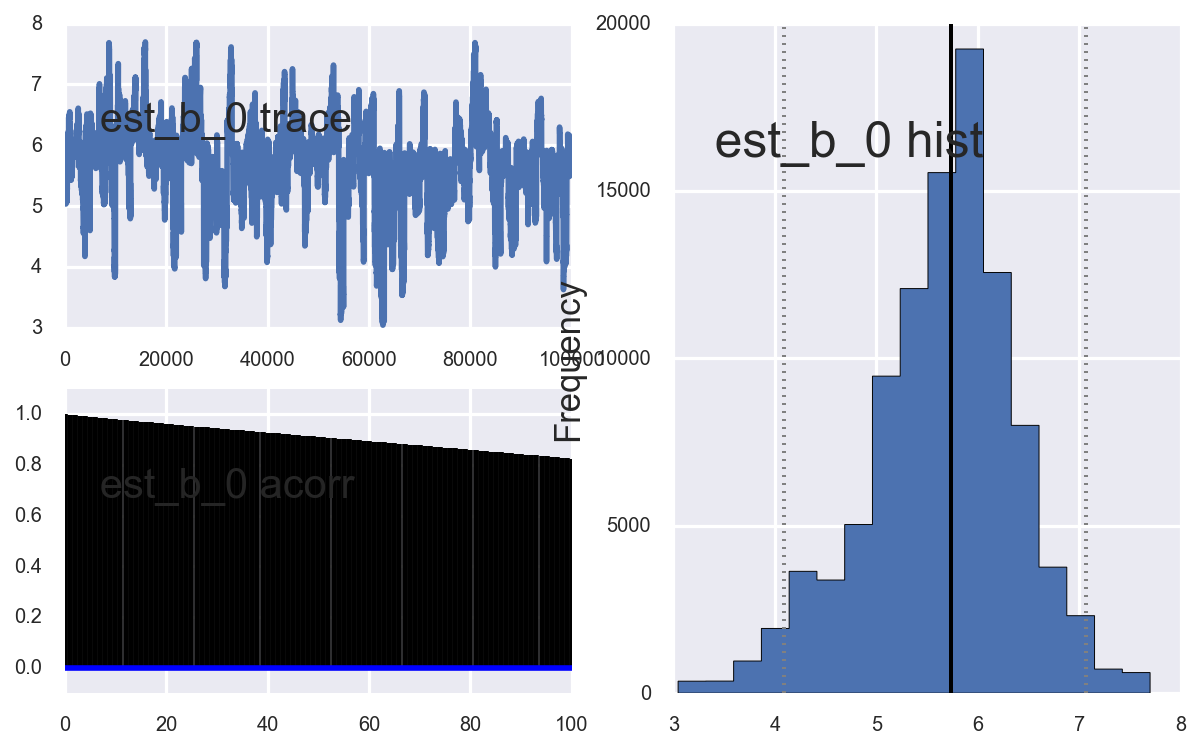

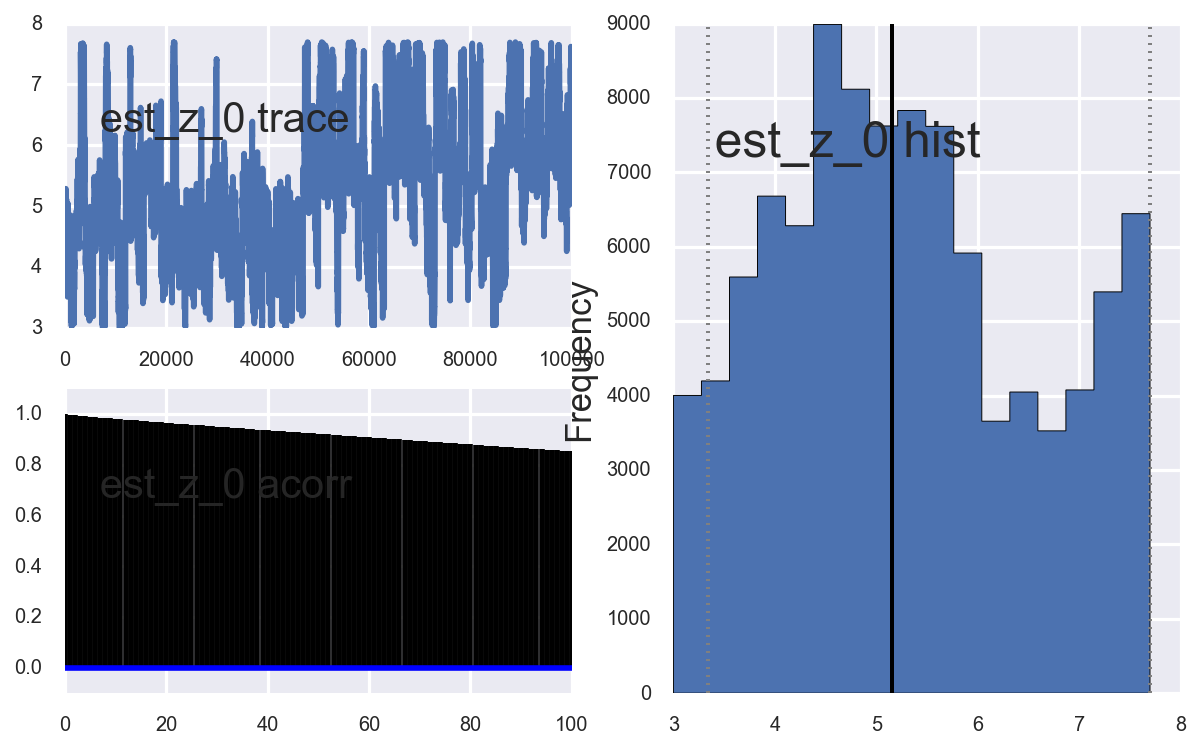

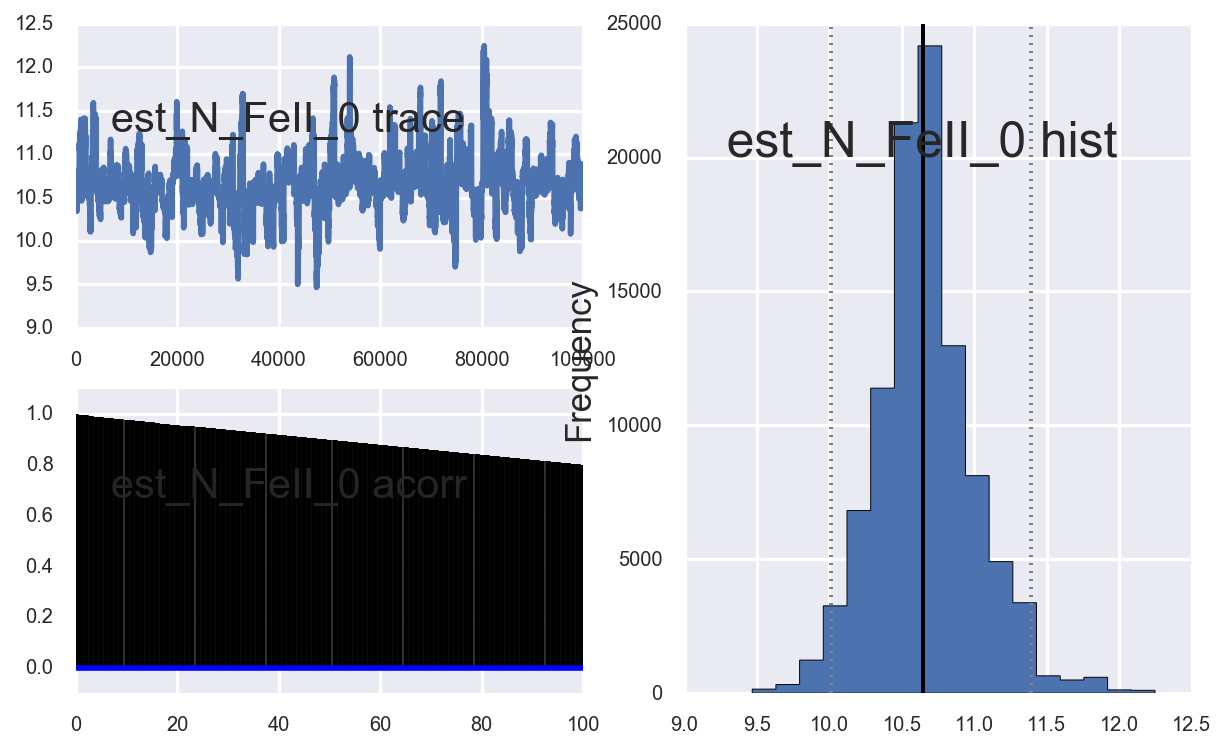

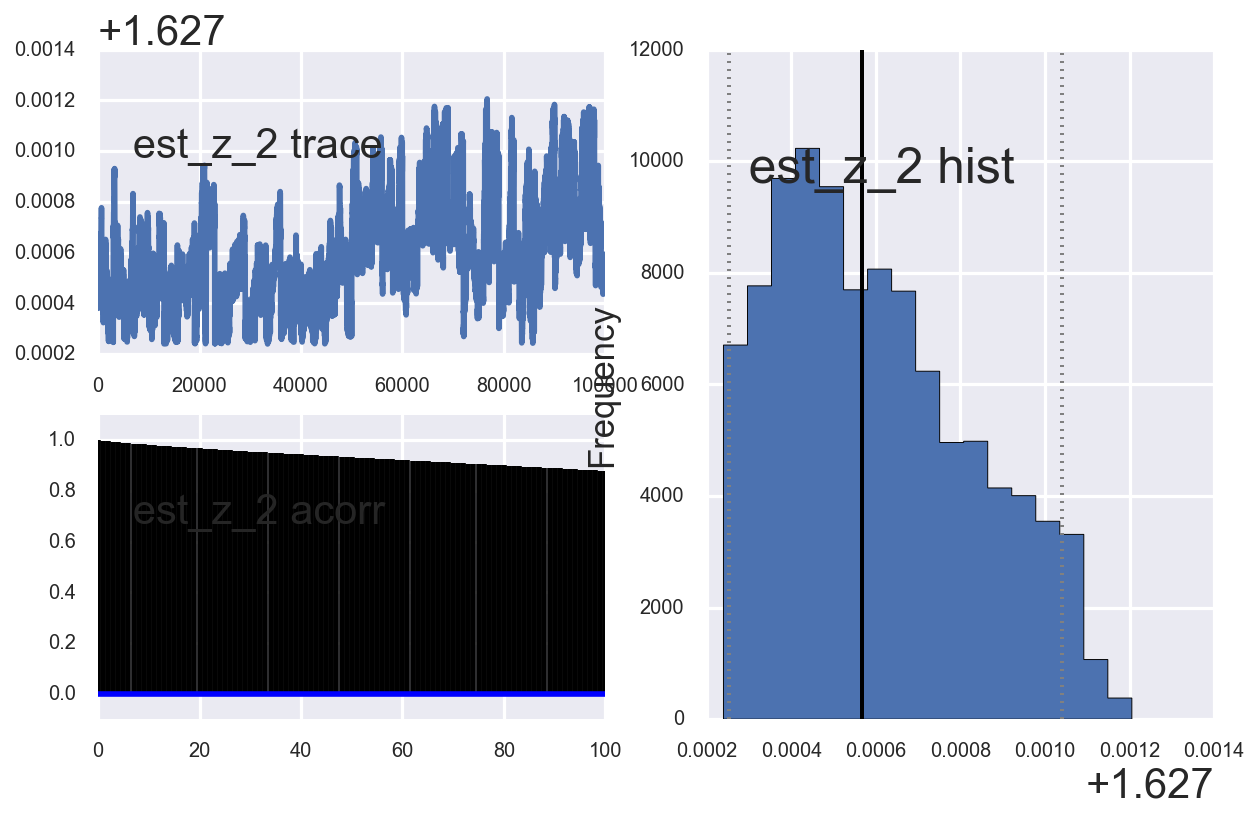

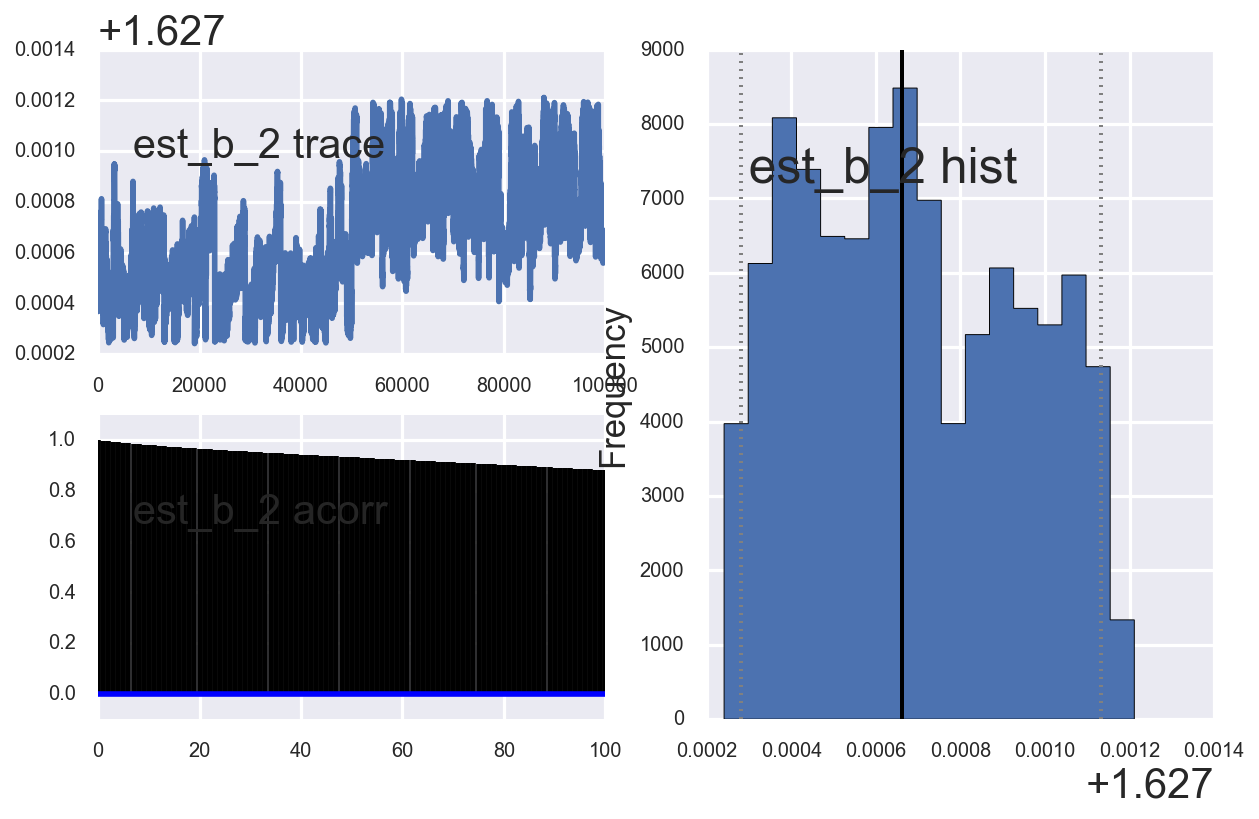

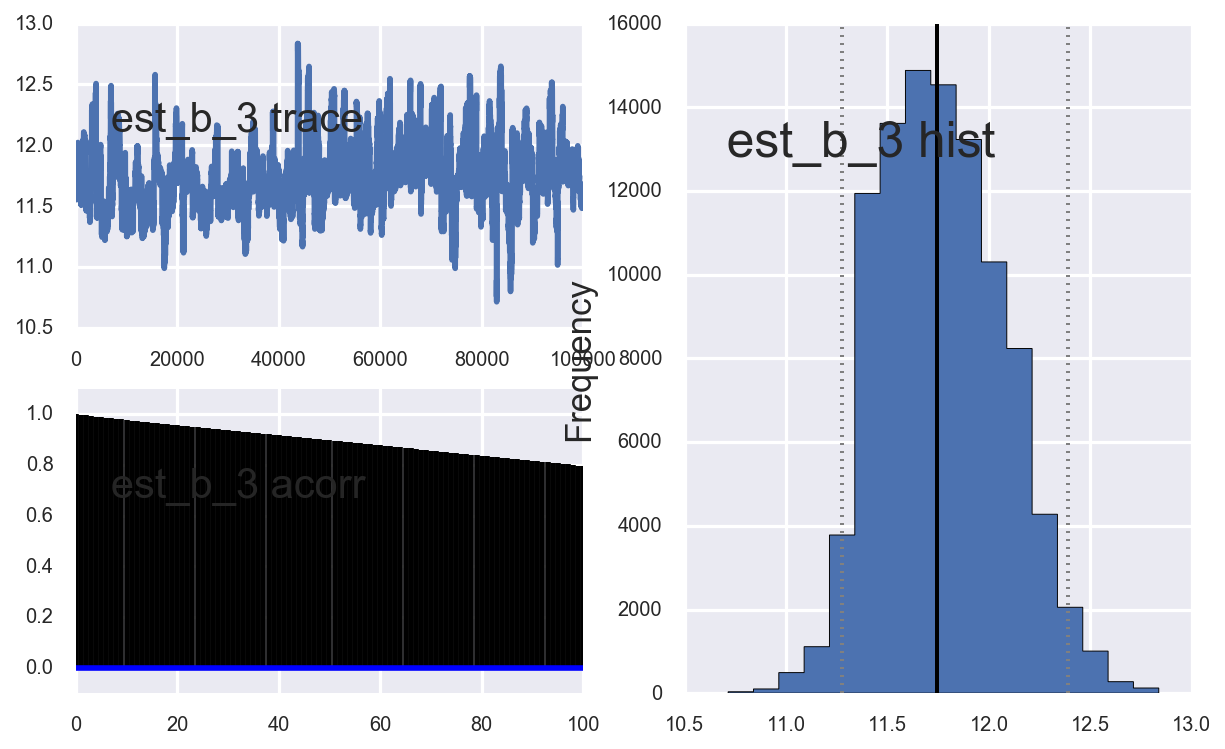

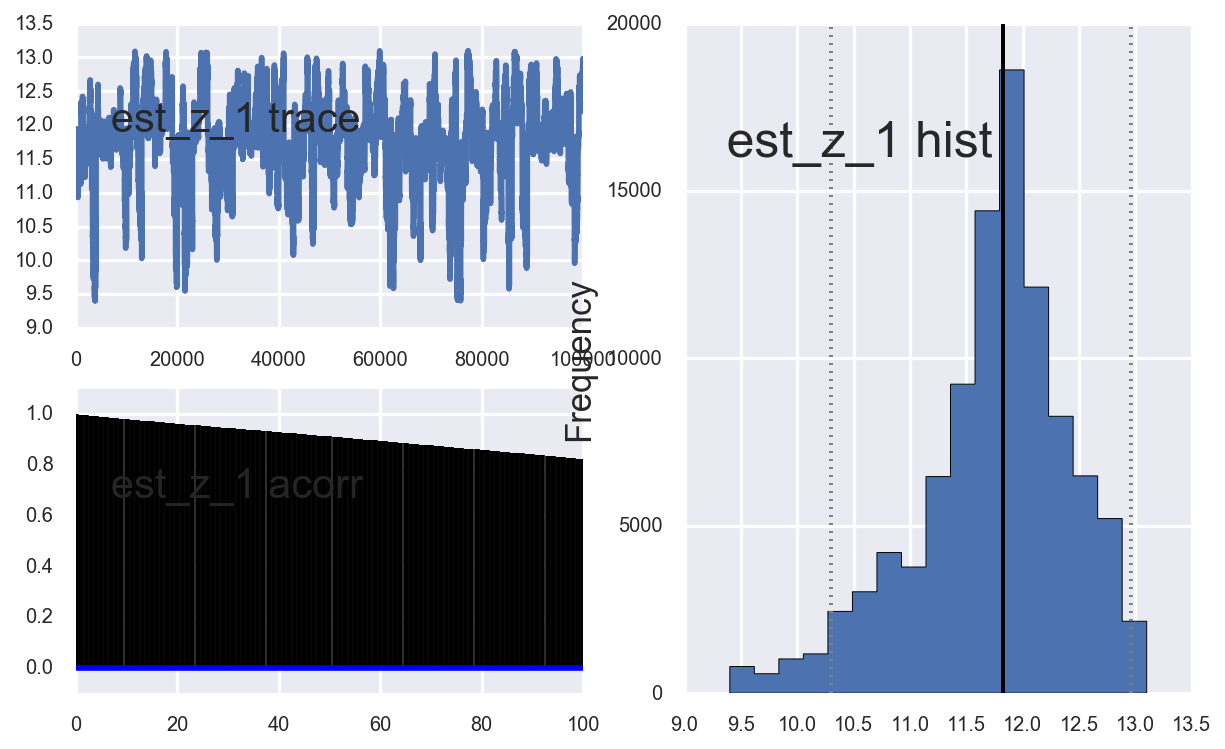

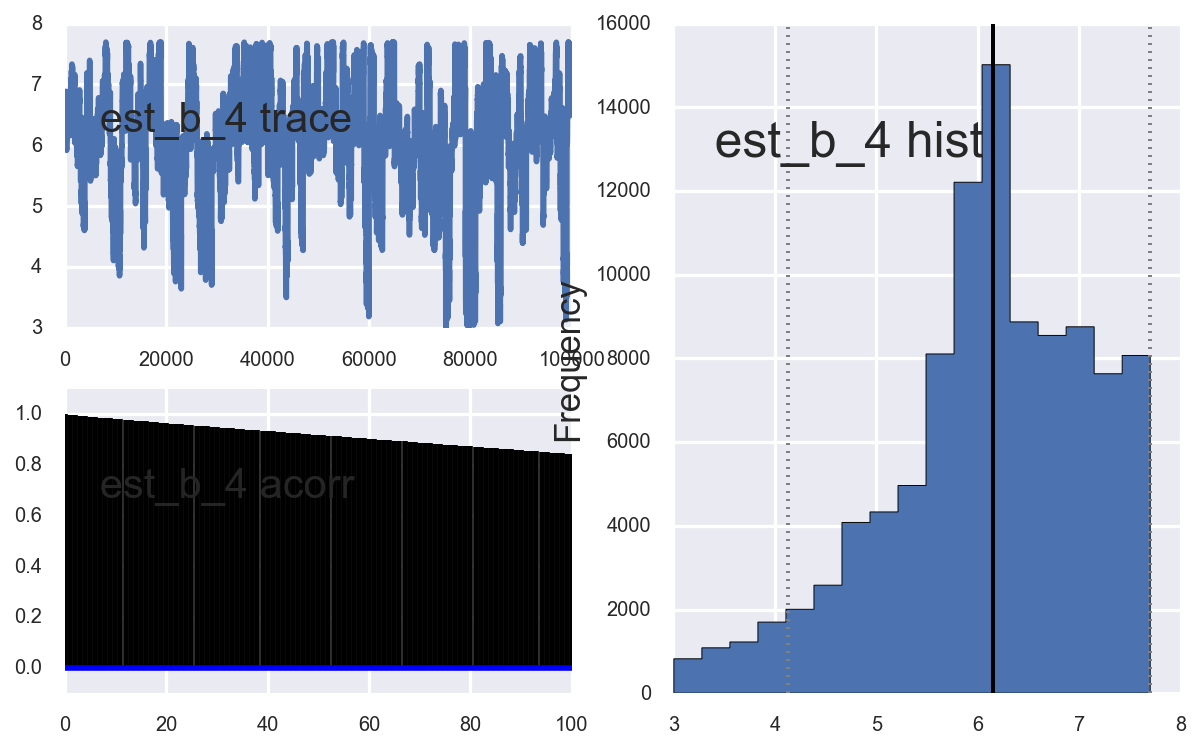

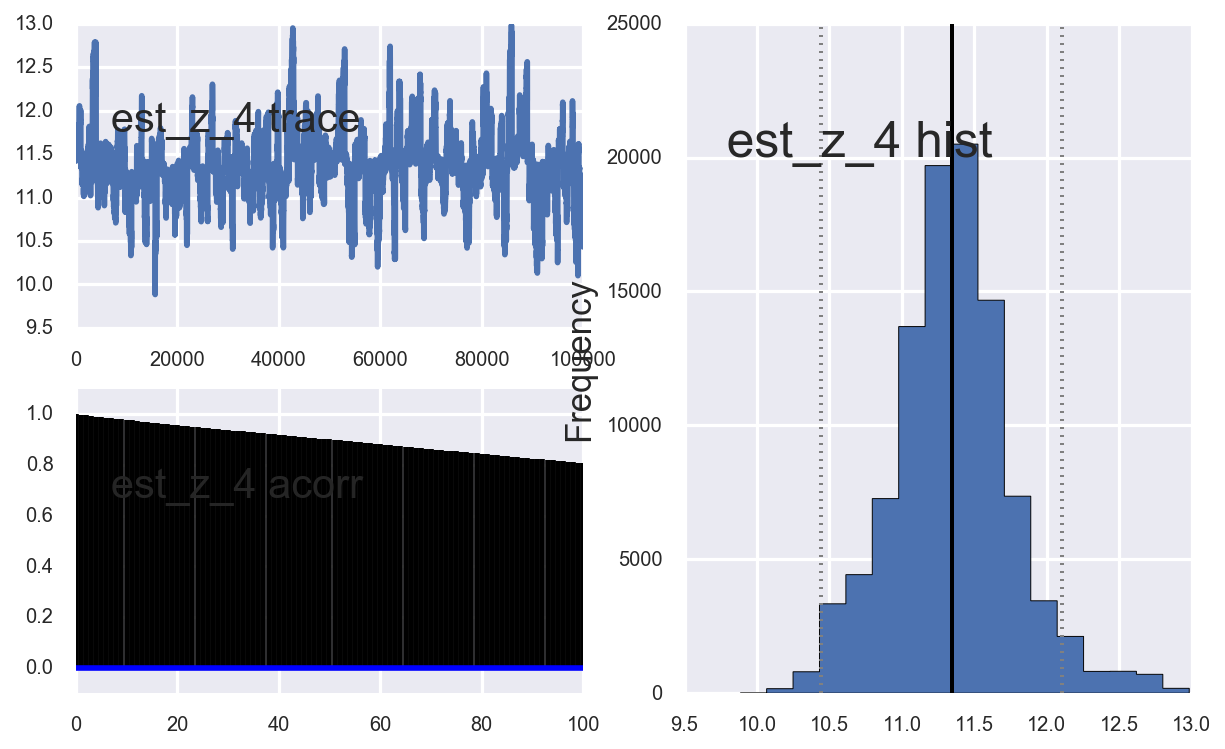

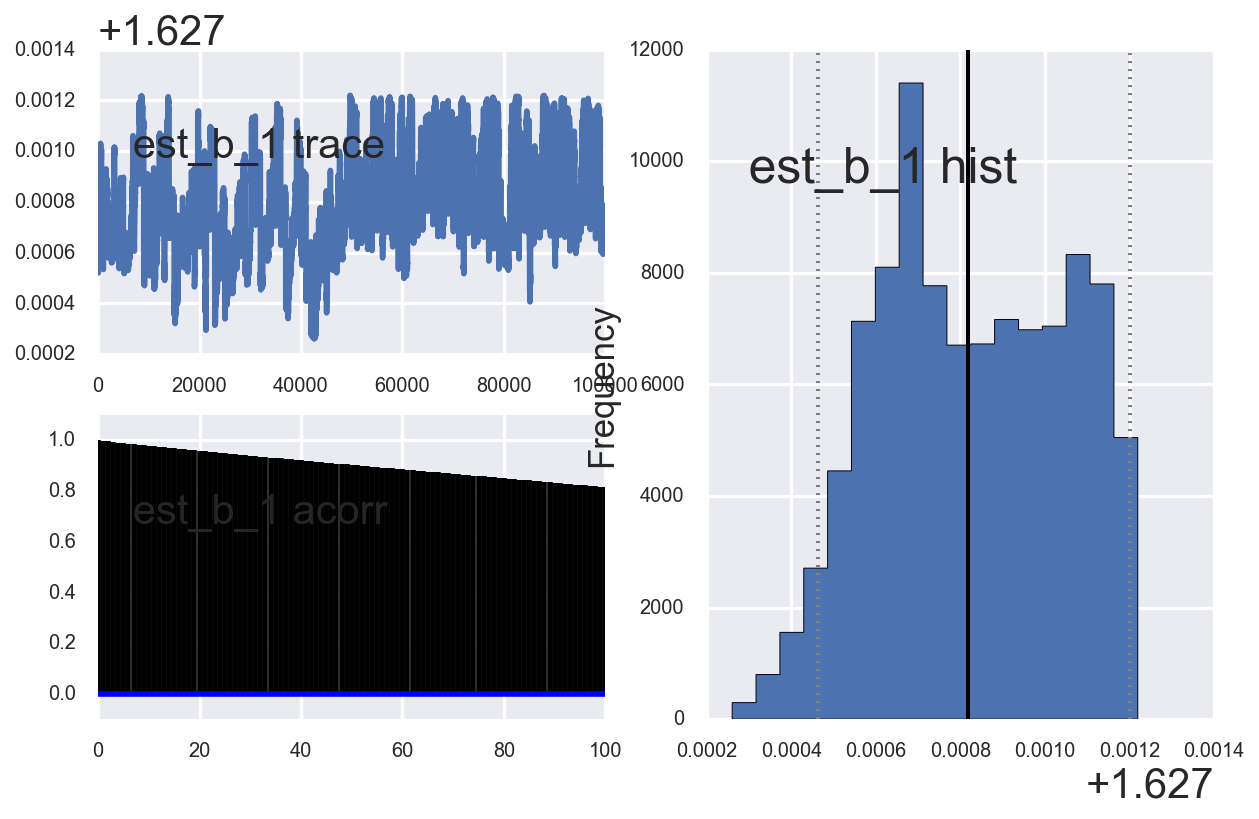

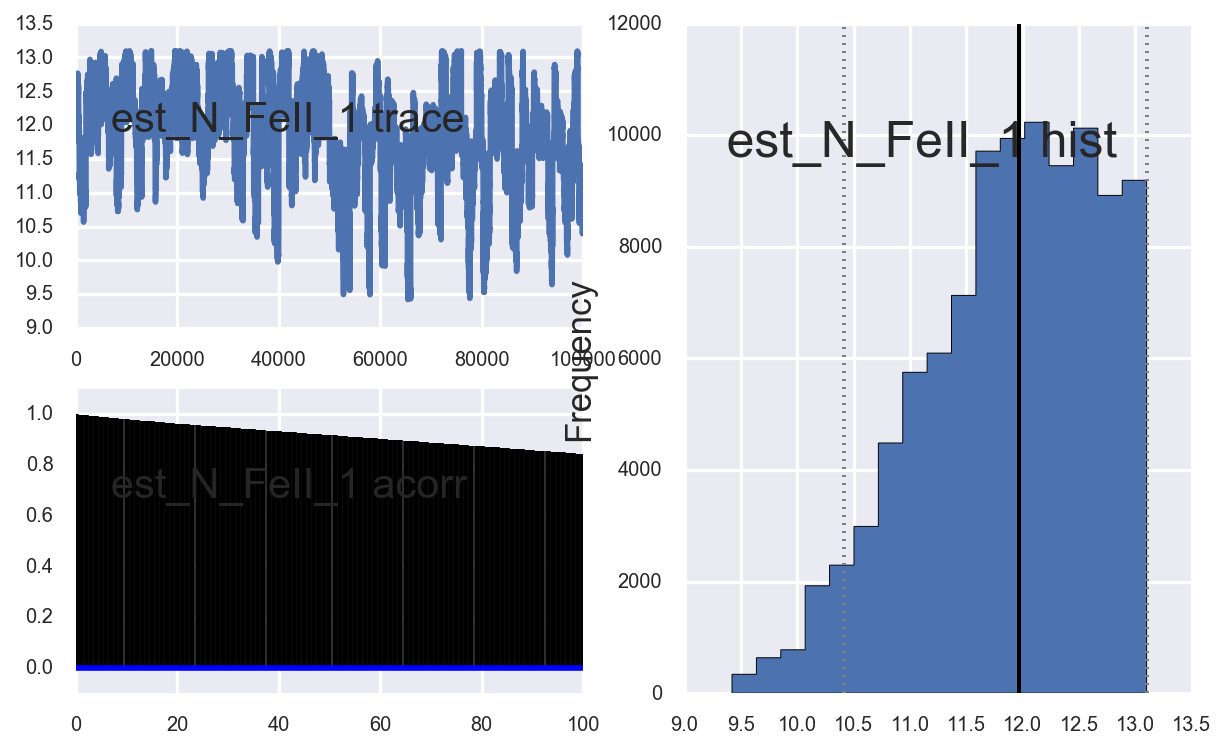

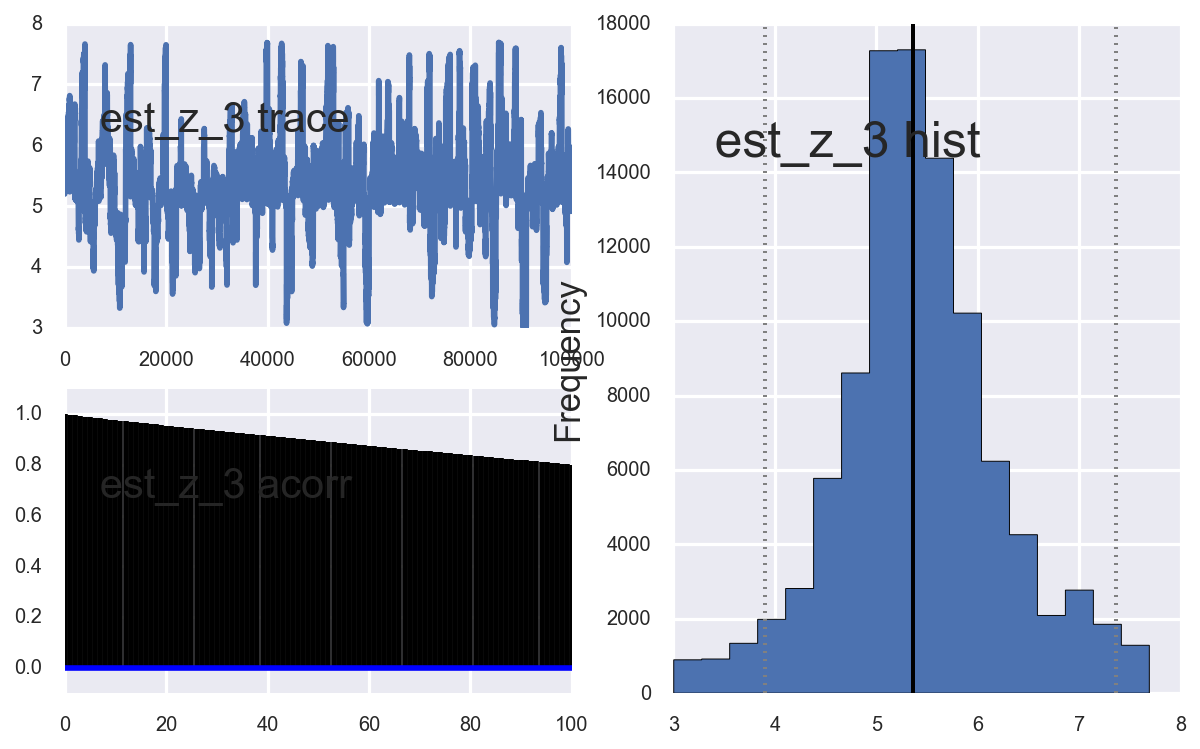

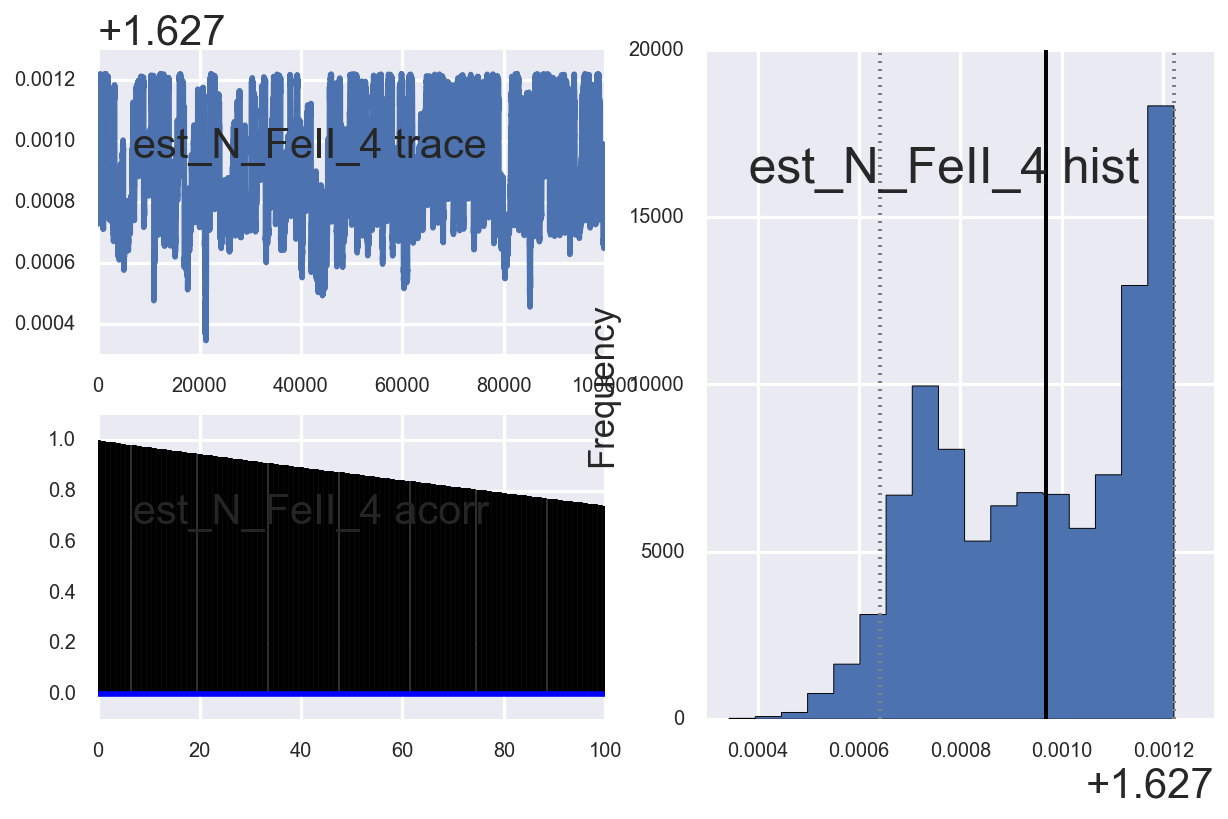

In [510]:
for i, var in enumerate(m.stochastics):
    var.trace._trace[0] = sampler.flatchain[:, i]

mc.Matplot.plot(mfinish)

In [582]:
newnewstart = [m_sample.trace(name)[trace_number] for name in sorted(names, key=lambda x: x.split('_')[-1])]

[1.6274960738919868,
 3.1142134809266921,
 11.872786031717862,
 1.6274768372410149,
 3.0757545215748667,
 12.472575574821395,
 1.6275445110177369,
 3.3681767872801456,
 12.173285146519003,
 1.6276786429421424,
 4.6946261662198205,
 12.419403066828634,
 1.6276947938337658,
 3.0019008171281132,
 11.994336195491135]

In [583]:
newstart

array([ 11.65616238,   5.81803626,   1.62764665,  10.63333333,
         5.91018392,   1.62764381,  11.63878648,   5.50243051,
         1.62764097,  11.40184461,   6.06666667,   1.62765801,
        11.83353568,   5.03647729,   1.62769959])

In [374]:
sampler.chain[:,-1][0]

array([ 11.67277317,   5.82122877,   1.62778016,  11.30209535,
         5.58393639,   1.62775287,  11.01498182,   4.90469262,
         1.62769315,  11.19960511,   5.37210844,   1.62771311,
        11.15906954,   5.23306359,   1.62767887])

In [ ]:
len(sampler.chain[:, :, 0])

In [ ]:
plt.plot(sampler.chain[:, :, 0]);

 ...]

In [415]:
len(sampler.chain[:, -1])

100

In [552]:
for endstate in sampler.chain[:, -1]:
    len(endstate)

In [573]:
[['FeII'] + x for x in list([np.array(blah)  for blah in endstate[[x+2, x+1, x]]] 
                                                                   for x in xrange(0, len(endstate), 3))]

[['FeII',
  array(1.6272543659639176),
  array(6.508636858451309),
  array(9.495944712418156)],
 ['FeII',
  array(1.627617557291785),
  array(6.3516488339399375),
  array(10.208782296130554)],
 ['FeII',
  array(1.6276404525229662),
  array(6.855081975890275),
  array(10.321535571045631)],
 ['FeII',
  array(1.6278755279215433),
  array(5.995365706061898),
  array(11.269369498393319)],
 ['FeII',
  array(1.6279877350993956),
  array(6.281481410422513),
  array(11.967405907301117)]]

In [574]:
final_fit[trace_number][0]

[['FeII',
  array(1.6272543659639176),
  array(6.508636858451309),
  array(9.495944712418156)],
 ['FeII',
  array(1.627617557291785),
  array(6.3516488339399375),
  array(10.208782296130554)],
 ['FeII',
  array(1.6276404525229662),
  array(6.855081975890275),
  array(10.321535571045631)],
 ['FeII',
  array(1.6278755279215433),
  array(5.995365706061898),
  array(11.269369498393319)],
 ['FeII',
  array(1.6279877350993956),
  array(6.281481410422513),
  array(11.967405907301117)]]

In [607]:
trace_dict = []
fit_flux = {}
final_fit = {}
# names = [parameter.__name__ for row in sorted(fit_component_parameters) for parameter in row[1:]]
for trace_number, endstate in enumerate(sampler.chain[:, -1]):
    final_fit[trace_number] = []
#     data = [m_sample.trace(name)[trace_number] for name in sorted(names, key=lambda x: x.split('_')[-1])]
    final_fit[trace_number].append([['FeII'] + x for x in list([np.array(blah) 
                                                                for blah in endstate[[x+2, x+1, x]]] 
                                                                   for x in xrange(0, len(endstate), 3))])
    fit_flux[trace_number] = {}
    for region_index, region_wavelength in enumerate(wavelength_list):
        fit_flux[trace_number][region_index] = {}
        flux = absorb.find_tau(subwavelength_list[region_index], final_fit[trace_number][0], atomDict, )[0]
        fit_flux[trace_number][region_index]['flux'] = co_add_from_subsample(convolve.convolve_psf(VoigtAbsorption(flux),
                                                                                     estimated_instrument_profile))
    trace_dict.append(fit_flux)


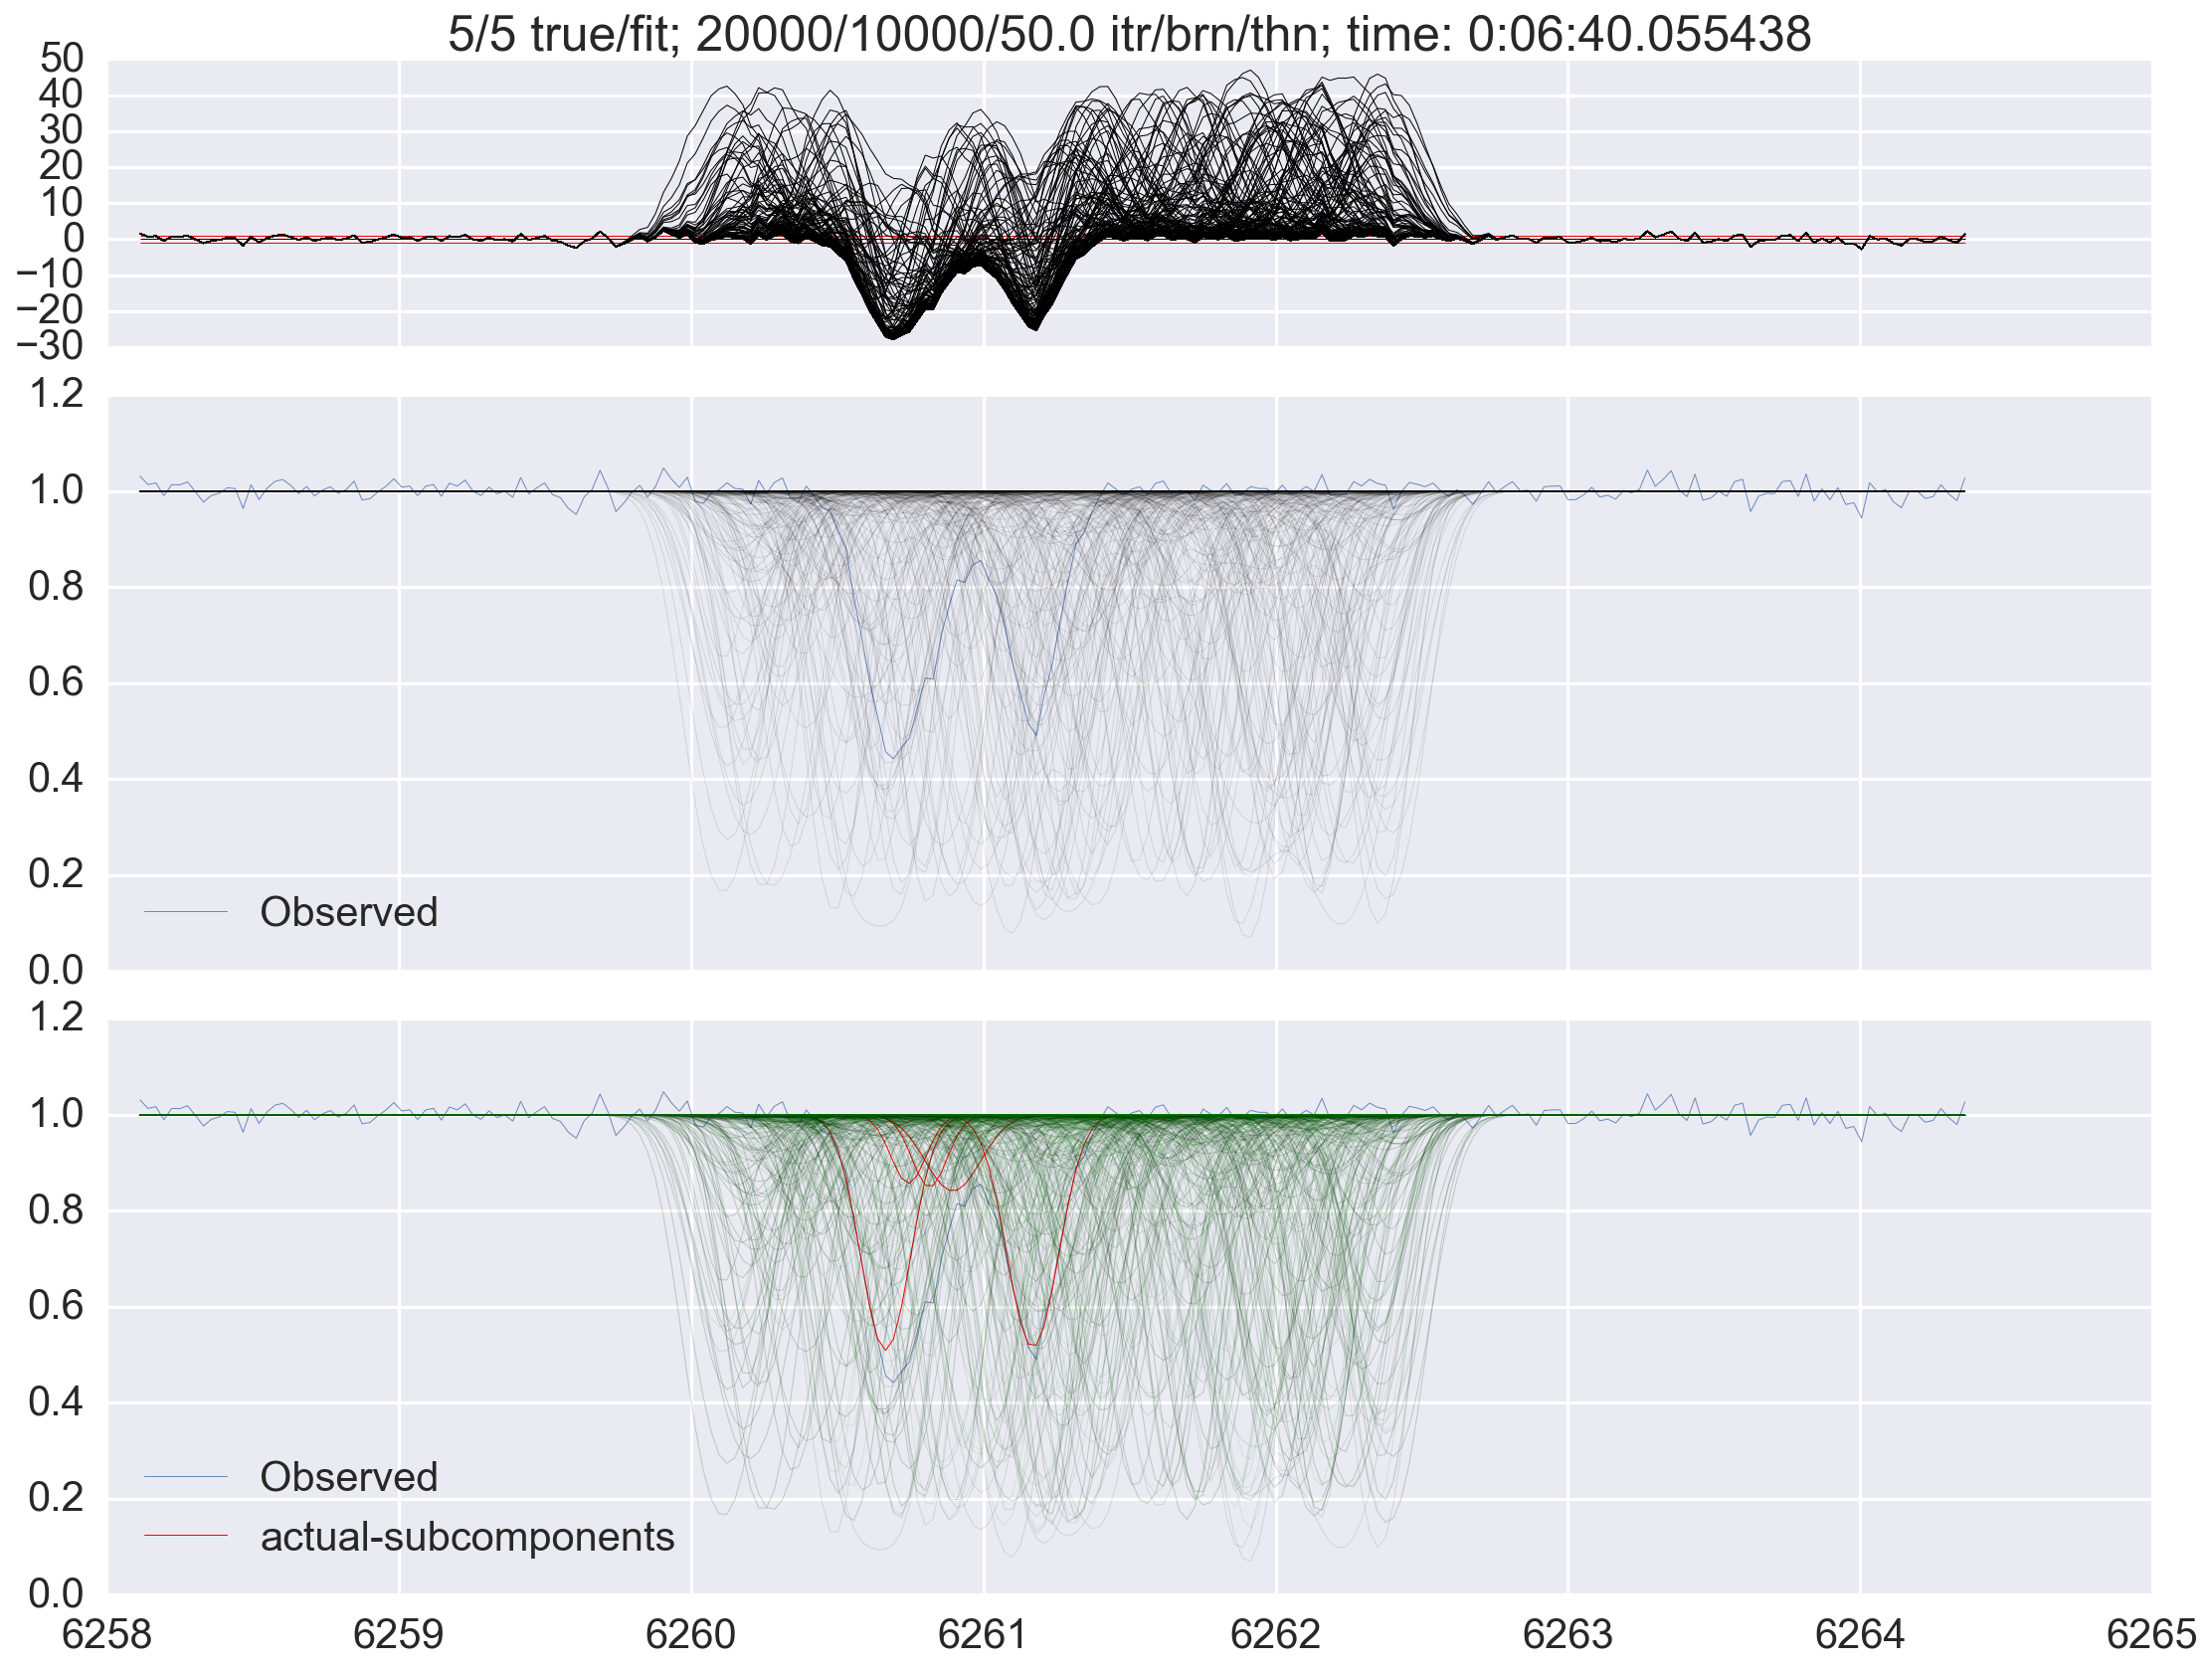

In [608]:
# pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")


for region_index, region_wavelength in enumerate(wavelength_list):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 2, 2])
    ax3 = plt.subplot(gs[2])
    ax1 = plt.subplot(gs[0], sharex=ax3)
    ax2 = plt.subplot(gs[1], sharex=ax3)
    ax1.hlines(1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax1.hlines(0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='black', 
                 lw=0.5,)
    ax1.hlines(-1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax2.plot(wavelength_list[region_index], gen_data[region_index], label="Observed",
                 alpha=0.8,
                 lw=0.5,
            )
    ax2.legend(loc='best')
    ax3.plot(wavelength_list[region_index], gen_data[region_index], label="Observed", 
                 alpha=0.8,
                 lw=0.5,
            )
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="red", label="actual-subcomponents", 
                 lw=0.5,)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="red", 
                 lw=0.5,)
    for trace_number, endstate in enumerate(sampler.chain[:, -1]):
        for final_index, row in enumerate(final_fit[trace_number][0]):
            flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
            flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
#             if final_index == 0:
#                 ax3.plot(wavelength_list[region_index], flux, color="green", label="fit-subcomponents", linewidth=1.0)
#             else:
            ax3.plot(wavelength_list[region_index], flux, color="green", lw=0.5, alpha=0.1)
        ax1.plot(wavelength_list[region_index], (gen_data[region_index] - fit_flux[trace_number][region_index]['flux']) / onesigmaerror, 
                 lw=0.5,
                 c='k'
                )
        ax2.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 alpha=0.1,
                 lw=0.5,
#                  label="Fit",
                )
        ax3.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 lw=0.5,
                 alpha=0.1,
                )
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit; " + str(iterations)+ "/" 
                  + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)
#     pdf.savefig()
#     plt.close()
# pdf.close()


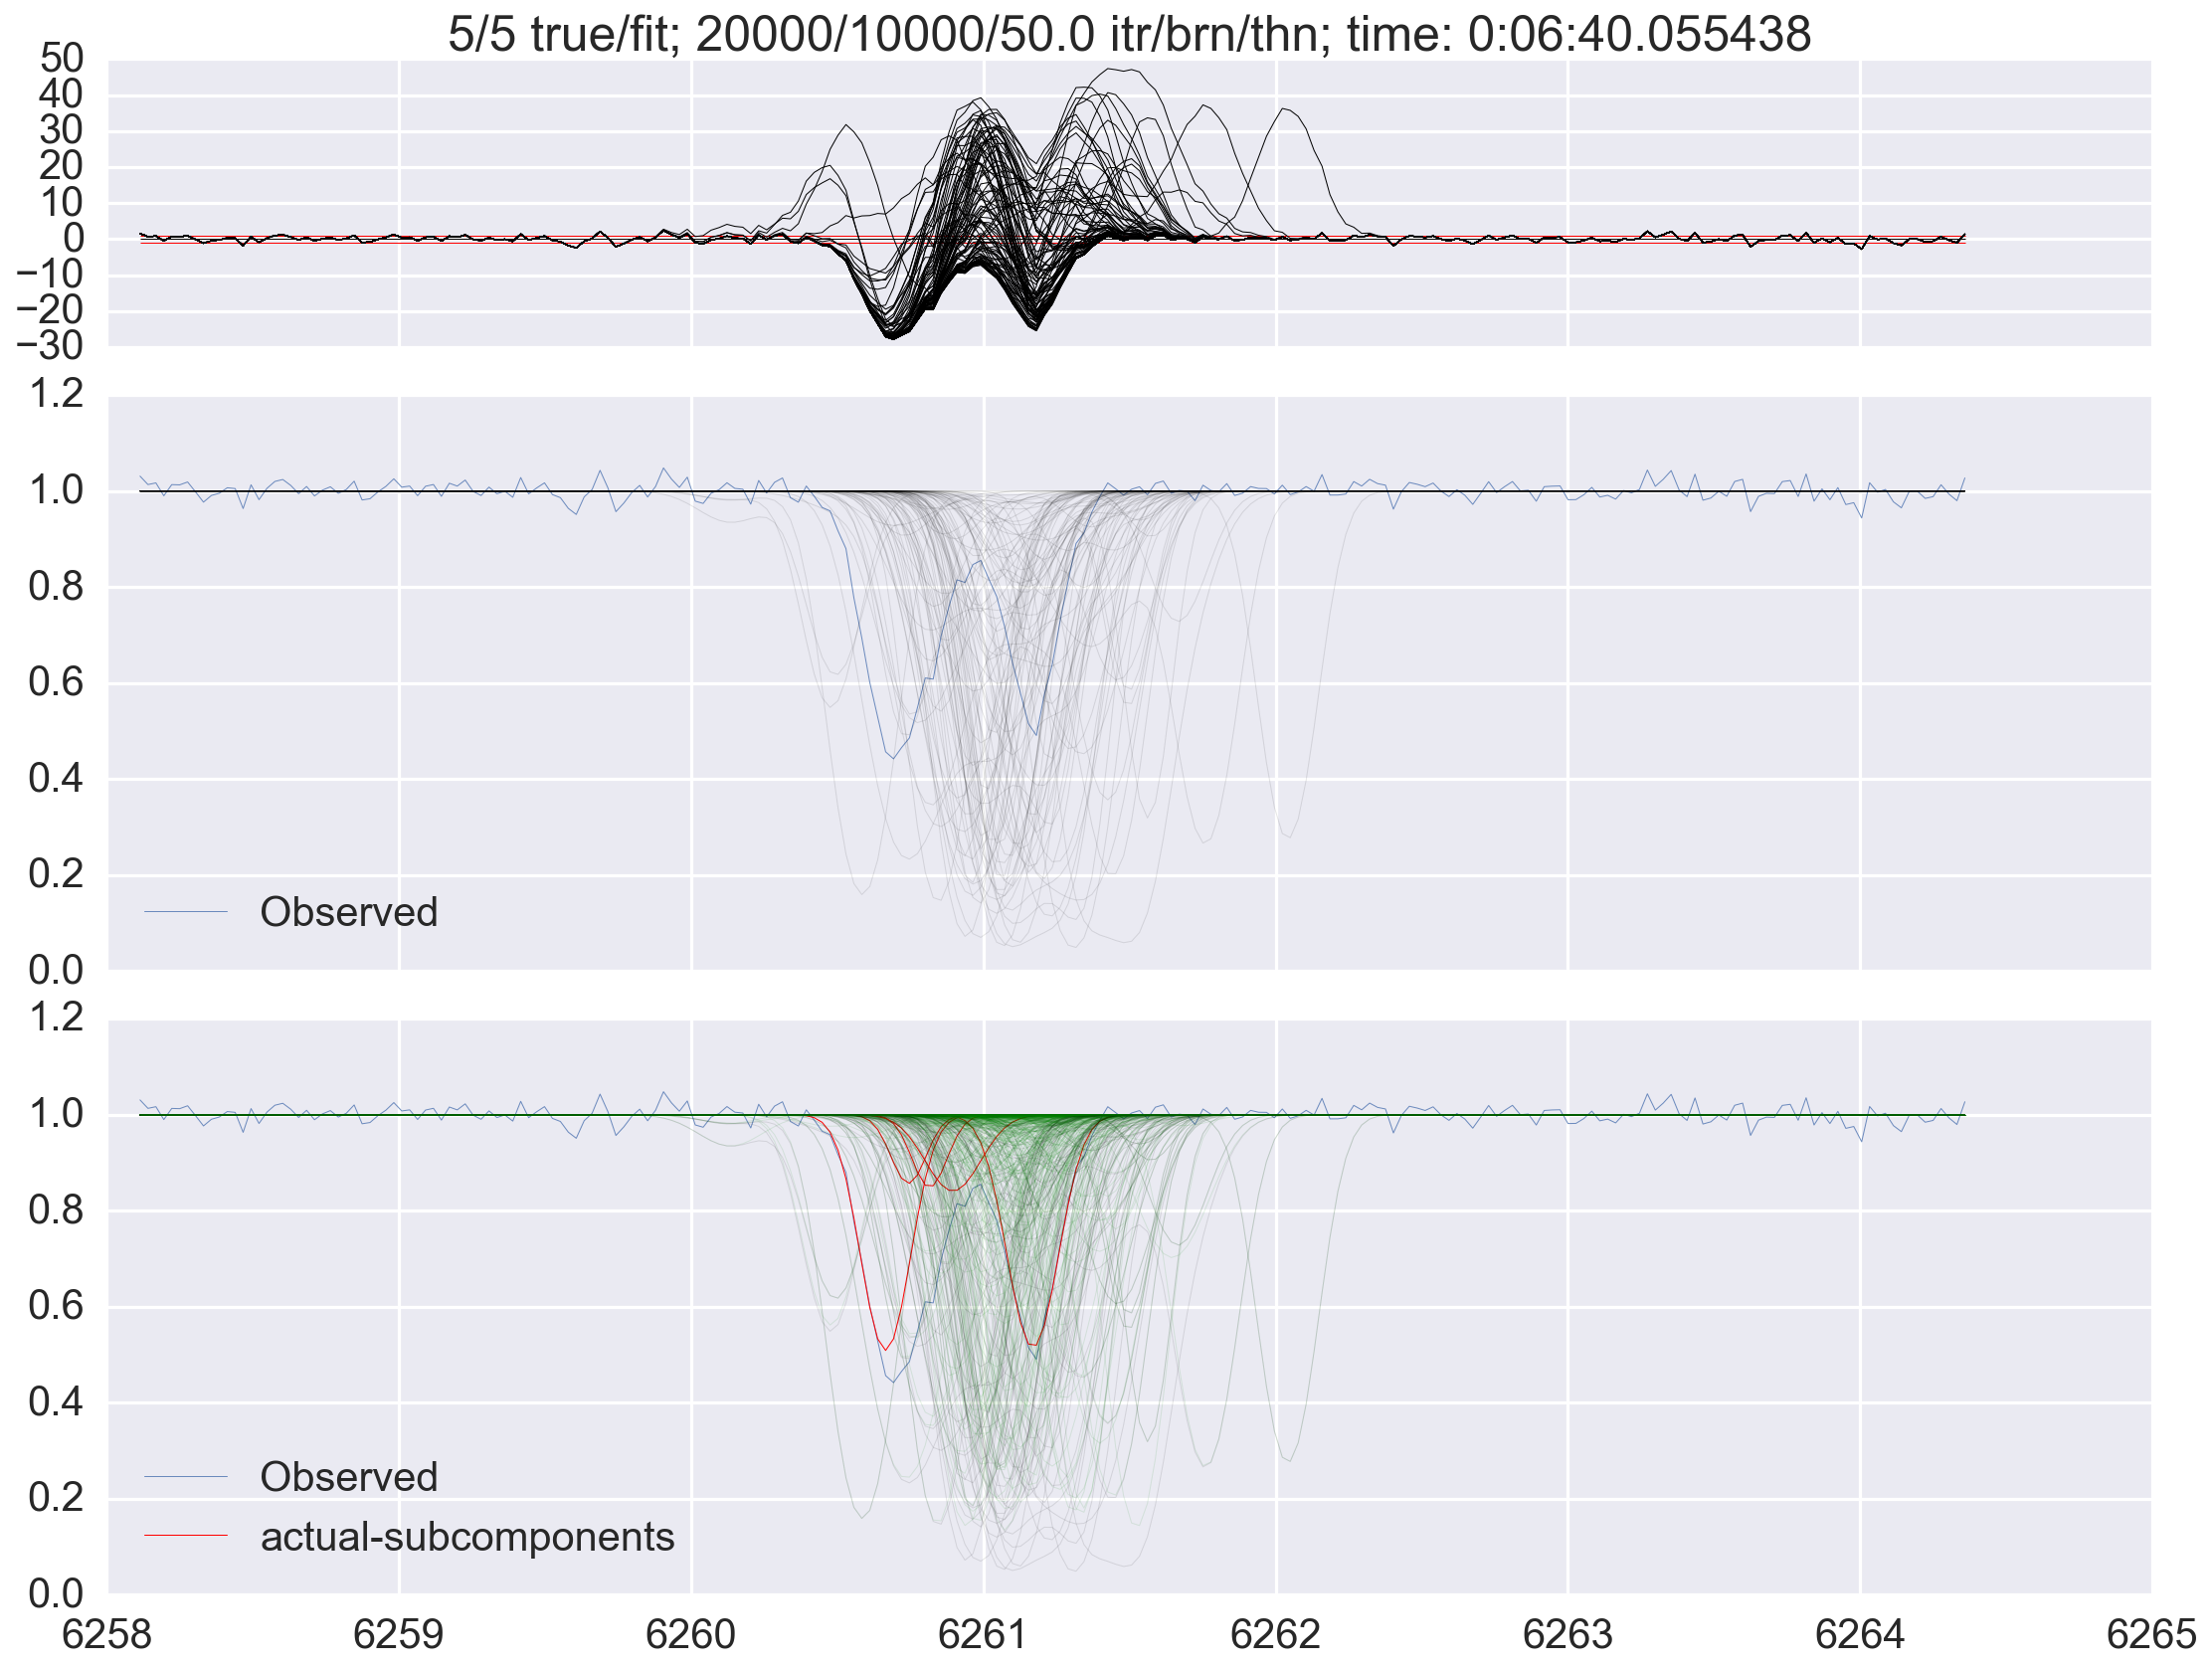

In [557]:
# pdf = PdfPages(datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S.flux") + ".pdf")


for region_index, region_wavelength in enumerate(wavelength_list):
    f = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 1, height_ratios=[1, 2, 2])
    ax3 = plt.subplot(gs[2])
    ax1 = plt.subplot(gs[0], sharex=ax3)
    ax2 = plt.subplot(gs[1], sharex=ax3)
    ax1.hlines(1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax1.hlines(0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='black', 
                 lw=0.5,)
    ax1.hlines(-1.0, wavelength_list[region_index][0], wavelength_list[region_index][-1], color='red', linestyles='-', 
                 lw=0.5,)
    ax2.plot(wavelength_list[region_index], gen_data[region_index], label="Observed",
                 alpha=0.8,
                 lw=0.5,
            )
    ax2.legend(loc='best')
    ax3.plot(wavelength_list[region_index], gen_data[region_index], label="Observed", 
                 alpha=0.8,
                 lw=0.5,
            )
    for observed_index, row in enumerate(true_component_parameters):
        flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
        flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
        if observed_index == 0:
            ax3.plot(wavelength_list[region_index], flux, color="red", label="actual-subcomponents", 
                 lw=0.5,)
        else:
            ax3.plot(wavelength_list[region_index], flux, color="red", 
                 lw=0.5,)
    for trace_number, endstate in enumerate(sampler.chain[:, -1]):
        for final_index, row in enumerate(final_fit[trace_number][0]):
            flux = absorb.find_tau(subwavelength_list[region_index], [row], atomDict, )[0]
            flux = convolve.convolve_psf(VoigtAbsorption(co_add_from_subsample(flux)), estimated_instrument_profile)
#             if final_index == 0:
#                 ax3.plot(wavelength_list[region_index], flux, color="green", label="fit-subcomponents", linewidth=1.0)
#             else:
            ax3.plot(wavelength_list[region_index], flux, color="green", lw=0.5,alpha=0.1)
        ax1.plot(wavelength_list[region_index], (gen_data[region_index] - fit_flux[trace_number][region_index]['flux']) / onesigmaerror, 
                 lw=0.5,
                 c='k'
                )
        ax2.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 alpha=0.1,
                 lw=0.5,
#                  label="Fit",
                )
        ax3.plot(wavelength_list[region_index], fit_flux[trace_number][region_index]['flux'], color='black', 
                 lw=0.5,
                 alpha=0.1,
                )
    ax3.legend(loc='best')
    ax3.xaxis.set_major_formatter(x_formatter)
    xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    plt.setp(xticklabels, visible=False)
    f.tight_layout()
    f.subplots_adjust(hspace=.10)
    ax1.set_title(str(true_components) + "/" 
                  + str(fit_components) 
                  + " true/fit; " + str(iterations)+ "/" 
                  + str(burn) + "/" + str(thin) + " itr/brn/thn; time: " + sampletime)
#     pdf.savefig()
#     plt.close()
# pdf.close()
